In [1]:
# import all the necessary libraries
# import basic libraries
import numpy as np
import pandas as pd
import math
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm

# import basic libraries for time series analysis
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error , mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

# import models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AR,ARResults #AR model
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults #ARIMAモデル
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

# import advanced methods of time series analysis
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

# Ignore harmless warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Here, I writes functions based on lectures and courses.


from statsmodels.tsa.stattools import adfuller
def adf_test(series, title = ""):
    """
    if you input series, the p-value of Augmented Dickey-Fuller test is returned.
    """
    print(f"Augumented Dickey-Fuller Test:{title}")
    result = adfuller(series.dropna(),autolag = "AIC") # .dropna() handles differenced data
    labels = ["ADS test statistic", "p-value", "# lags used", "# observations"] # # stands for number
    out = pd.Series(result[0:4],index = labels)

    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val
    print(out.to_string()) # .to_string() omit "dtype:float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    return result[1]

#Create functions to implement ADF test and plots the output

def plot_series(series, figsize = (9,6), title = "", model = "add"):
    """
    Plot seasonal factors of series
    """
    season = seasonal_decompose(series,model = model)
    season.plot();

def plot_property(series, title = "", num = 30):
    """
    Plot the date and its lag-1 data as well as ACF and PACF
    """
    lag_plot(series)
    plot_acf(series,lags = num, title = f"{title} ACF")
    plot_pacf(series,lags = num,title = f"{title} PACF")


def all_plot(data, title = "", figsize = (12,9),model = "add", season = False, acf = False ,num = 30,col = 2):
    """
    Plot all the input data one by one. 
    At the same time, you can choose to produce ACF and PACF
    """
    columns = data.columns
    fig, axes = plt.subplots(nrows= math.ceil(len(columns)/col), ncols=col, dpi=120, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i <= len(columns)-1:
            df = data[data.columns[i]]
            ax.plot(df, linewidth=1)
            ax.set_title(data.columns[i])
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')
            ax.spines["top"].set_alpha(0)
            ax.tick_params(labelsize=6)
            plt.subplots_adjust(hspace=0.6)
    for column in columns:
        if season == True:
            plot_series(data[column],title = column, model = model,figsize = figsize)
        if acf == True:
            plot_property(data[column], title = column, num = num)



def auto_adf(data):
    """
    This functions shows how many times the series need to be differenced.
    However, one difference seems better in general, or you can omit the data.
    ---------
    num_dic shows how many times the series need to be differenced
    """
    num = len(data.columns)
    num_dic = {}
    for x in range(num):
        result = adf_test(data.iloc[:,x])
        diff_num = 0
        series = data.iloc[:,x].diff()
        while result > 0.05:
            result = adf_test(series)
            series = series.diff()
            diff_num = diff_num + 1
        print(f"{data.columns[x]} needs {diff_num} times difference to obtain stationary")
        num_dic[data.columns[x]] = diff_num
        print("--------------------------------")
    return num_dic

#diffを行う回数分差分を取り，それを再びデータとして加える．
def differencing_data(data):
    """
    This function combines with auto_diff function
    so that this function can automatically difference data as it requires,
    and return another data frame as an output.
    """
    #make a new data frame, which requires the same index of the original data
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx)
    # Get the output of the function as a dictionary, and difference as it requires.
    dic_data = auto_adf(data)
    num = len(data.columns)
    for x in range(num):
        series = data.iloc[:,x]
        diff_num = dic_data[data.columns[x]]
        diff_times = 0
        while diff_times != diff_num:
            series = series.diff()
            diff_times = diff_times + 1
        #add series to the new_data
        new_data[f"{data.columns[x]}_{diff_num}"] = series
    return new_data.dropna()


#予測の関数を作る,　蜜柑
#VARforecast関数に投入するtrainデータにはnot positive definiteの列を加えてはならない
#------Q. not positive definiteとなる列をどのように処理するのか？？--------
def VARforecast(data,num = 5,order = 7):
    """
    In order to predict with VAR model, the data should be stationary.
    Be careful not to cause the error for not positive definite matrix.
    Therefore, selected variables should not have multicollinearity
    In the dataset of yearly USA data, RIR_1 and Turnover_Ratio_1 need deleting．
    """
    use_data= differencing_data(data)
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    return df_forecast.dropna()

maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test',set_p_value =0.05, verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            #p_values = [test_result[i+1][0][test][1] for i in range(maxlag)]
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            if min_p_value < set_p_value or min_p_value == 1:
                df.loc[r, c] = min_p_value
            else:
                df.loc[r, c] = False
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#Cointegration test
def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary_
    print(f'Name   ::  Test Stat > C({(1-alpha)*100}%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


#Plot two data at the same time
def compare_plot(series1,series2,size = (12,6),title1 = "", title2 = "", legend = True, tight = True):
    """
    二つのデータを同時にプロット
    Plot two data simultaneously
    """
    ax = series1.plot(figsize = size, legend = legend, title = title1)
    ax.autoscale(axis = "x", tight = tight)
    dx = series2.plot(figsize = size, legend = legend, title = title1)
    dx.autoscale(axis = "x", tight = tight)

# Put the forecast values to the original values 
def reverse_data(original_data, num = 5, order = 7):
    """
    VAR requires the data of stationary. 
    Now, this function let forecast add to the original considering the difference.
    This function combines with the VARforecast function.
    VARforecast also combines with differencing_data function.
    """
    df_forecast = VARforecast(original_data,num = num,order = order)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
    return new_data.dropna()

#Plot data to compare．
def FvsA_plot(data,col = 2,num = 5,order = 7):
    """
    Plot the data to compare the forecast with the actual data.
    This function just requres the original data as an input
    because this function combines with the reverse_data function.
    """
    reverse = reverse_data(data, num = num,order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)

# Evaluate関数
def forecast_evaluation(forecast, actual):
    """
    This function prepares the evaluation of forecast.
    """
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def forecast_accuracy(data,col = 2, num = 5, order = 7):
    """
    This function shows the evaluation of forecast value compared to the actual one.
    This function combines with the forecast_evaluation function.
    """
    reverse = reverse_data(data,num = num,)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_evaluation(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")


def Durbin_Watson(data,num = 5,order = 7):
    """
    Doing Durbin_Watson test so that the data needs to be differenced.
    Then, the stationary is tested.
    the model would be chosen to realize the min AIC.
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))

In [3]:
# Here are the functions in case not to difference for cointegration
# nodiffではreverseも必要ない
def VARforecast_nodiff(data,num = 5,order = 7):
    """
    This function uses VAR model and is used for cointegrated variables.
    Therefore, this function does not difference date.
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    return df_forecast

def FvsA_plot_nodiff(data,col = 2,num = 5):
    """
    Plot the forecast and actual values for cointegrated variables.
    """
    reverse = VARforecast_nodiff(data, num = num)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax)
        test[col][-num:].plot(legend= True, ax=ax).autoscale(axis='x',tight=True);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} Forecast",f"{col} Actual"])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)


def forecast_data_nodiff(data,col = 2, num = 5):
    """
    Compare the forecast and actual.
    This function also skip diffeerencing and reversing.
    """
    reverse = VARforecast_nodiff(data,num = num,)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")


def Durbin_Watson_nodiff(data,num = 5,order = 7):
    """
    Implement Durbin_Watson for the input data without differencing．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))

In [21]:
# These functions are bulit to meet the criteria of FRED-MD.
def adjust_data(data,dic):
    """
    Create a function to change data based on tranformation code and return a new dataframe.
    The transformation code is obtained from FRED-MD.
    THe meaning of transformation code is written below
    (1) no transformation
    (2) delta x_t
    (3) delta^2 x_t
    (4) log(x_t)
    (5) delta(log(x_t))
    (6) delta^2(log(x_t))
    (7)delta(x_t/x_{t-1} - 1)
    """
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx,columns = [k for k in dic.keys()])
    # change the data at each column, and add it to the new dataframe
    for key, val in dic.items():
        # if the code is 1, no transformation is required
        if val == 1:
            new_data[key] = data[[key]]
    
        # if the code is 2, the data needs one differentiation
        if val == 2:
            new_data[key] = data[[key]].diff()

        # if the code is 3, the data needs differentiation twice
        if val == 3:
            new_data[key] = data[[key]].diff().diff()

        # if the code is 4, the data needs to take its logarithm
        if val == 4:
            new_data[key] = data[[key]].apply(np.log)

        # if the code is 5, the data needs to take its logarithm and differntiation once
        if val == 5:
            new_data[key] = data[[key]].apply(np.log).diff()
          
        # if the code is 6, the data needs to take its rogarithm and differentiation twice
        if val == 6:
            new_data[key] = data[[key]].apply(np.log).diff().diff()
        
        # if the code is 7, the data needs to be divided by its lag-1 value and minus one, and then take its differentiation
        if val == 7:
            new_data[key] = data[[key]].dropna().pct_change().diff()
    return new_data.dropna()

# ARmode
def ARmodel(data,dic,num = 5,order = 6):
    """
    You need to input stationary data.
    The function automatically forecast with AR model.
    You can input DataFrame.
    The function returns the forecasts of variables and their lags in AR models as a dictionary.
    """
    train = data[:-num]
    test = data[-num:]    
    lags = {}
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(index = idx,columns = data.columns)
    for key in dic.keys():
        result_AIC = {}
        result_BIC = {}
        for i in range(1,order):
            model = AR(train[[key]])
            result = model.fit(i)
            result_AIC[i] = result.aic
            result_BIC[i] = result.bic
        min_AIC = min(result_AIC, key=result_AIC.get)
        min_BIC = min(result_BIC, key = result_BIC.get)
        md = AR(train[key])
        result = md.fit(min_AIC)
        print(result.summary())
        lag_order = result.k_ar
        lags[key] = lag_order
        start = len(train)
        end = len(train) + len(test) - 1
        forecast = result.predict(start = start ,end = end)
        idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
        df_forecast[key] = pd.DataFrame(forecast)
    return df_forecast,lags # return is two variables

# Predict the future with VAR model
def VARmodel(data,dic,num = 5,order = 7,orth = True,figsize =(11,11)):
    """
    Here, we aim to forecast the future values of selected variables.
    This function connects to adjust_data function.
    Do not confuse with VARforecast, which uses diff_data function.
    VARforecast does not depend on FRED-MD
    You need to input stationary data.
    If you choose orth = True, the orthogonal impulse respnse is plotted 
    """
    train = data[:-num]
    test = data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order)
    irf.plot(orth=orth)
    #irf.set_size_inches(12,8)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("-------------Durbin Watson test is ended------------------")
    return df_forecast.dropna()

# This function reverse the stationary data to the original scale
def revert_forecast(original_data,forecast,dic,num = 5,order = 7):
    """
    This function aims to reverse the forecasted data to the original one.
    The function requires the transformation code as well
    (1) no transformation
    (2) delta x_t
    (3) delta^2 x_t
    (4) log(x_t)
    (5) delta(log(x_t))
    (6) delta^2(log(x_t))
    (7)delta(x_t/x_{t-1} - 1)
    """
    idx = pd.date_range(forecast.index[0],periods = len(forecast.index),freq = forecast.index.freq)
    new_data = pd.DataFrame(index = idx,columns = [k for k in dic.keys()])
    diff_data = pd.DataFrame(index = idx,columns = [k for k in dic.keys()])
    for key, val in dic.items():
        # if the code is 1, no transformation is required
        if val == 1:
            new_data[key] = forecast[key]
        # if the code is 2, the data needs one differentiation
        if val == 2:
            new_data[key] = original_data[key].iloc[-num-1] + forecast[key].cumsum()
        # if the code is 3, the data needs differentiation twice
        if val == 3:
            diff_data[key] = original_data[key].iloc[-num-1] - original_data[key].iloc[-num-2]+forecast.cumsum()
            new_data[key] = original_data[key].iloc[-num-1] + diff_data[key].cumsum()
    
        # if the code is 4, the data needs to take its logarithm
        if val == 4:
            new_data[key] = forecast[key].apply(math.exp)
        # if the code is 5, the data needs to take its logarithm and differntiation once
        if val == 5:
            diff_data[key] = np.log(original_data[key].iloc[-num-1]) + forecast[key].cumsum()
            new_data[key] = diff_data[key].apply(math.exp)
        
        # if the code is 6, the data needs to take its rogarithm and differentiation twice
        if val == 6:
            diff_data[key] = np.log(original_data[key].iloc[-num-1]) - np.log(original_data[key].iloc[-num-2]) + forecast[key].cumsum()
            new_data[key] = np.log(original_data[key].iloc[-num-1]) + diff_data[key].cumsum()
            new_data[key] = new_data[key].apply(math.exp)
        
        # if the code is 7, the data needs to be divided by its lag-1 value and minus one, and then take its differentiation
        if val == 7:
            diff_data[key] = original_data[key].pct_change()[-num-1] + forecast[key][-num:].cumsum()
            for i in range(num):
                if i == 0:
                    new_data[key][i] = (1+diff_data[key][i])*original_data[key][-num-1]
                else:
                    new_data[key][i] = (1+diff_data[key][i])*new_data[key][i-1]        
            new_data[key] = data[key].dropna().pct_change().diff()
    return new_data.dropna()

# Plot and Evaluation

def evaluate_plot(data,dic,col = 2,num = 5,order = 7,test = 'ssr_chi2test',verbose = False):
    """
    Plot the data to compare the forecast with the actual data.
    This function just requres the original data as an input
    because this function combines with the reverse_data function.
    The function also evaluates the model at the same time
    """
    test = data.dropna()[-num:]
    # change the data to stationary
    df = adjust_data(data,dic)
    # make a list of keys in the dictionary
    keys = [k for k in dic.keys()]
    # set the figure size in accordance with the number of keys
    figsize = (len(keys)*2.5,len(keys)*2.5)
    # Check Granger Causality
    #grangers_causation_matrix(df[keys].dropna(),variables = keys, test = test, verbose = verbose)
    # predict the future with AR model and VAR model
    ar,lag = ARmodel(df,dic,num = num,order = order)
    var = VARmodel(df,dic,num = num,order = 7,figsize = figsize)
    # reverse the data to the original scale
    ar_reverse = revert_forecast(data,ar,dic,num = num,order = order)
    var_reverse = revert_forecast(data,var,dic,num = num, order = order)
    # plot part
    fig, axes = plt.subplots(nrows= math.ceil(len(keys)/col), ncols= col, dpi=150, figsize=figsize)
    for i, (col,ax) in enumerate(zip(keys, axes.flatten())):
        ar_reverse[keys[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        var_reverse[keys[i]].plot(legend = True, ax = ax)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} AR Forecast",f"{col} VAR Forecast",f"{col} Actual"])
        #ax.xaxis.set_ticks_position('none')
        #ax.yaxis.set_ticks_position('none')
        #ax.spines["top"].set_alpha(0)
        #ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    # evaluation part
    for i in range(len(keys)):
        print(f"{keys[i]} AR Accuracy")
        accuracy_prod = forecast_evaluation(ar_reverse[keys[i]].values,test[keys[i]])#valueはなくていいのか？
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        print(f"{keys[i]} VAR Accuracy")
        accuracy_prod = forecast_evaluation(var_reverse[keys[i]].values,test[keys[i]])#valueはなくていいのか？
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    return lag # returns the list of the AR lags for each variable.

def coin_evaluate_plot(data,dic,col = 2,num = 5,order = 7,test = 'ssr_chi2test',verbose = False):
    """
    Plot the data to compare the forecast with the actual data.
    This function just requres the original data as an input.
    However! the veriables should be cointegrated.
    because this function combines with the reverse_data function.
    The function also evaluates the model at the same time
    """
    test = data.dropna()[-num:]
    # change the data to stationary
    df = data.copy()
    # make a list of keys in the dictionary
    keys = [k for k in dic.keys()]
    # set the figure size in accordance with the number of keys
    figsize = (len(keys)*2.5,len(keys)*2.5)
    # Check Granger Causality
    #grangers_causation_matrix(df[keys].dropna(),variables = keys, test = test, verbose = verbose)
    # predict the future with AR model and VAR model
    ar,lag = ARmodel(df,dic,num = num,order = order)
    var = VARmodel(df,dic,num = num,order = 7,figsize = figsize)
    # no need to reverse the data to the original scale
    ar_reverse = ar
    var_reverse = var
    # plot part
    fig, axes = plt.subplots(nrows= math.ceil(len(keys)/col), ncols= col, dpi=150, figsize=figsize)
    for i, (col,ax) in enumerate(zip(keys, axes.flatten())):
        ar_reverse[keys[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        var_reverse[keys[i]].plot(legend = True, ax = ax)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} AR Forecast",f"{col} VAR Forecast",f"{col} Actual"])
        #ax.xaxis.set_ticks_position('none')
        #ax.yaxis.set_ticks_position('none')
        #ax.spines["top"].set_alpha(0)
        #ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    # evaluation part
    for i in range(len(keys)):
        print(f"{keys[i]} AR Accuracy")
        accuracy_prod = forecast_evaluation(ar_reverse[keys[i]].values,test[keys[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        print(f"{keys[i]} VAR Accuracy")
        accuracy_prod = forecast_evaluation(var_reverse[keys[i]].values,test[keys[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    return lag # returns the list of the AR lags for each variable.



In [5]:
def all_compare(data,compare = "S_P500",col = 2,legend = True, tight = True,figsize = (15,15)):
    data = data.dropna()
    compare_series = data[compare]
    data = data.drop(compare,axis = 1)
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=figsize)
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        data[col].plot(legend=legend, ax=ax)
        compare_series.plot(legend=legend, ax=ax).autoscale(axis='x',tight=tight);
        #plt.legend(fontsize=16, loc='upper right')
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col}",f"{compare}"],fontsize=5, loc='upper left')
        plt.subplots_adjust(hspace=2)
    for i in range(len(data.columns)):
        prod = forecast_evaluation(data[data.columns[i]].values,compare_series)#valueはなくていいのか？
        print(f"Compare {data.columns[i]} with {compare} Mathmatically")
        for k, v in prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")

In [6]:
# USA = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/FYP_USA.csv",index_col= "TIme",header = 0, parse_dates = True)
# USA.index.freq = "YS"
# USA.columns

# import datasets gained from FRED-MD
original_data = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/current.csv",
                   index_col = "sasdate",
                   header = 0,
                   parse_dates = True,
                   dtype='float')

data = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/current_nocode.csv",
                   index_col = "sasdate",
                   header = 0,
                   parse_dates = True,
                   dtype='float')
data.index.freq = "MS"

code = original_data[:1]
#pull the transformation code and save it in a dictionary to adjust data for later analysis.
transformation_code = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values)}

# making a new data and delete the transformation code
USA = data.copy()
USA = USA.loc["11/1/2011":"12/1/2019"].dropna()
USA.index.freq = "MS"
data.head()

# change the data as expected in the FRED-MD
df = adjust_data(USA,transformation_code)

# # conduct augmented Dickey-Fuller test just in case.
# weak_stationary = []
# for col in roop_adf(df):
#     weak_stationary.append(f"{col} {transformation_code[col]}")
USA.head()

RPI  W875RX1  DPCERA3M086SBEA  CMRMTSPLx   RETAILx   INDPRO  \
sasdate                                                                         
2011-11-01  13591.318  11209.0           98.833  1250048.0  391589.0  98.2433   
2011-12-01  13714.357  11322.6           98.893  1261003.0  391837.0  98.7876   
2012-01-01  13776.131  11426.0           99.363  1268460.0  395376.0  99.3925   
2012-02-01  13861.174  11514.2           99.960  1273029.0  400228.0  99.6203   
2012-03-01  13911.509  11555.5           99.763  1271849.0  401804.0  99.1551   

            IPFPNSS  IPFINAL   IPCONGD  IPDCONGD  ...  DSERRG3M086SBEA  \
sasdate                                           ...                    
2011-11-01  98.7842  99.1006  100.9840   98.5863  ...           98.538   
2011-12-01  99.2532  99.4251  100.9198   99.2185  ...           98.735   
2012-01-01  99.6775  99.8527  100.8708  101.7504  ...           99.065   
2012-02-01  99.9366  99.9601  100.7393  101.0506  ...           99.256   
2012-03-01  99.2333  99.1711   99.1562  100.0007  ...           99.410   

            CES0600000008  CES2000000008  CES3000000008  UMCSENTx    MZMSL  \
sasdate                                                                      
2011-11-01          20.75          23.73          18.96      63.7  10574.3   
2011-12-01          20.79          23.78          19.00      69.9  10625.4   
2012-01-01          20.78          23.71          19.02      75.0  10708.1   
2012-02-01          20.82          23.78          19.00      75.3  10752.7   
2012-03-01          20.88          23.90          19.02      76.2  10818.1   

            DTCOLNVHFNM   DTCTHFNM     INVEST  VXOCLSx  
sasdate                                                 
2011-11-01    275083.08  811994.07  2484.9812  31.4830  
2011-12-01    276945.17  816723.75  2493.3557  24.5547  
2012-01-01    277522.76  814355.55  2526.4347  19.1781  
2012-02-01    278361.80  812714.86  2567.0044  16.6353  
2012-03-01    280232.73  813331.10  2581.3367  14.6666  

[5 rows x 128 columns]

In [6]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
data_matrix = grangers_causation_matrix(df.dropna(),variables=USA.columns,set_p_value =0.01)
data_matrix

RPI_x W875RX1_x DPCERA3M086SBEA_x CMRMTSPLx_x RETAILx_x  \
RPI_y                   1     False             False       0.001     False   
W875RX1_y           False         1             False      0.0009     False   
DPCERA3M086SBEA_y   False     False                 1       False     False   
CMRMTSPLx_y         False     False             False           1     False   
RETAILx_y           False     False             False       False         1   
INDPRO_y            False     False             False      0.0018         0   
IPFPNSS_y           False     False            0.0004      0.0001    0.0001   
IPFINAL_y           False     False            0.0005      0.0004    0.0002   
IPCONGD_y           False     False            0.0007      0.0026     False   
IPDCONGD_y          False     False             False      0.0039         0   
IPNCONGD_y          False     False             False       False     False   
IPBUSEQ_y           False     False             False      0.0003    0.0001   
IPMAT_y             False     False             False       False         0   
IPDMAT_y            False     False             False       0.001    0.0005   
IPNMAT_y            False     False             False       False     0.002   
IPMANSICS_y         False     False            0.0006      0.0021         0   
IPB51222S_y         False     False             False       False     False   
IPFUELS_y           False     False             False      0.0036     False   
CUMFNS_y            False     False            0.0005      0.0019         0   
HWI_y               False     False             False       False     False   
HWIURATIO_y         False     False             False       False     False   
CLF16OV_y           False     False             False       False     False   
CE16OV_y           0.0002    0.0003            0.0024       False     False   
UNRATE_y            0.007    0.0075             False       False     0.001   
UEMPMEAN_y          False     False             False       False    0.0001   
UEMPLT5_y           False     False             False       False     False   
UEMP5TO14_y        0.0075     0.007            0.0006       False     False   
UEMP15OV_y          False     False             False       False         0   
UEMP15T26_y         False     False            0.0009       False     False   
UEMP27OV_y          False     False             False       False     False   
CLAIMSx_y           0.001    0.0009             False       False    0.0007   
PAYEMS_y            False     False             False       False     False   
USGOOD_y           0.0054    0.0025             False       False     False   
CES1021000001_y     False     False             False       False    0.0063   
USCONS_y            False     False             False       False     False   
MANEMP_y           0.0092    0.0071             False       False     False   
DMANEMP_y          0.0014    0.0016             False      0.0063    0.0075   
NDMANEMP_y          False     False             False       False     False   
SRVPRD_y            False     False             False       False     False   
USTPU_y             False     False             False       False     False   
USWTRADE_y         0.0005    0.0007            0.0098       False     False   
USTRADE_y           False     False             False       False     False   
USFIRE_y            False     False             False       False     False   
USGOVT_y            False     False             False       False     False   
CES0600000007_y     False     False             False       False     False   
AWOTMAN_y           False     False             False       False     False   
AWHMAN_y            False     False             False       False     False   
HOUST_y             False     False             False       False    0.0035   
HOUSTNE_y           False     False             False       False     False   
HOUSTMW_y           False     False             False      0.0004     

Compare RPI with S&P 500 Mathmatically
mape : 1.1303
mean : -0.0075
mae : 0.0215
mpe : -0.9128
rmse : 0.0275
corr : -0.1497
minmax : 3.3772
----------------------------
Compare W875RX1 with S&P 500 Mathmatically
mape : 1.1379
mean : -0.0075
mae : 0.0216
mpe : -0.9147
rmse : 0.0279
corr : -0.1393
minmax : 4.1076
----------------------------
Compare DPCERA3M086SBEA with S&P 500 Mathmatically
mape : 1.1483
mean : -0.0076
mae : 0.0208
mpe : -0.9714
rmse : 0.0258
corr : 0.062
minmax : 0.6352
----------------------------
Compare CMRMTSPLx with S&P 500 Mathmatically
mape : 1.1434
mean : -0.0078
mae : 0.0211
mpe : -0.8906
rmse : 0.0267
corr : -0.0666
minmax : 0.6713
----------------------------
Compare RETAILx with S&P 500 Mathmatically
mape : 1.4832
mean : -0.0067
mae : 0.0203
mpe : -0.9058
rmse : 0.0252
corr : 0.1894
minmax : 1.7866
----------------------------
Compare INDPRO with S&P 500 Mathmatically
mape : 1.2663
mean : -0.0087
mae : 0.0216
mpe : -1.0394
rmse : 0.027
corr : -0.0944
minmax

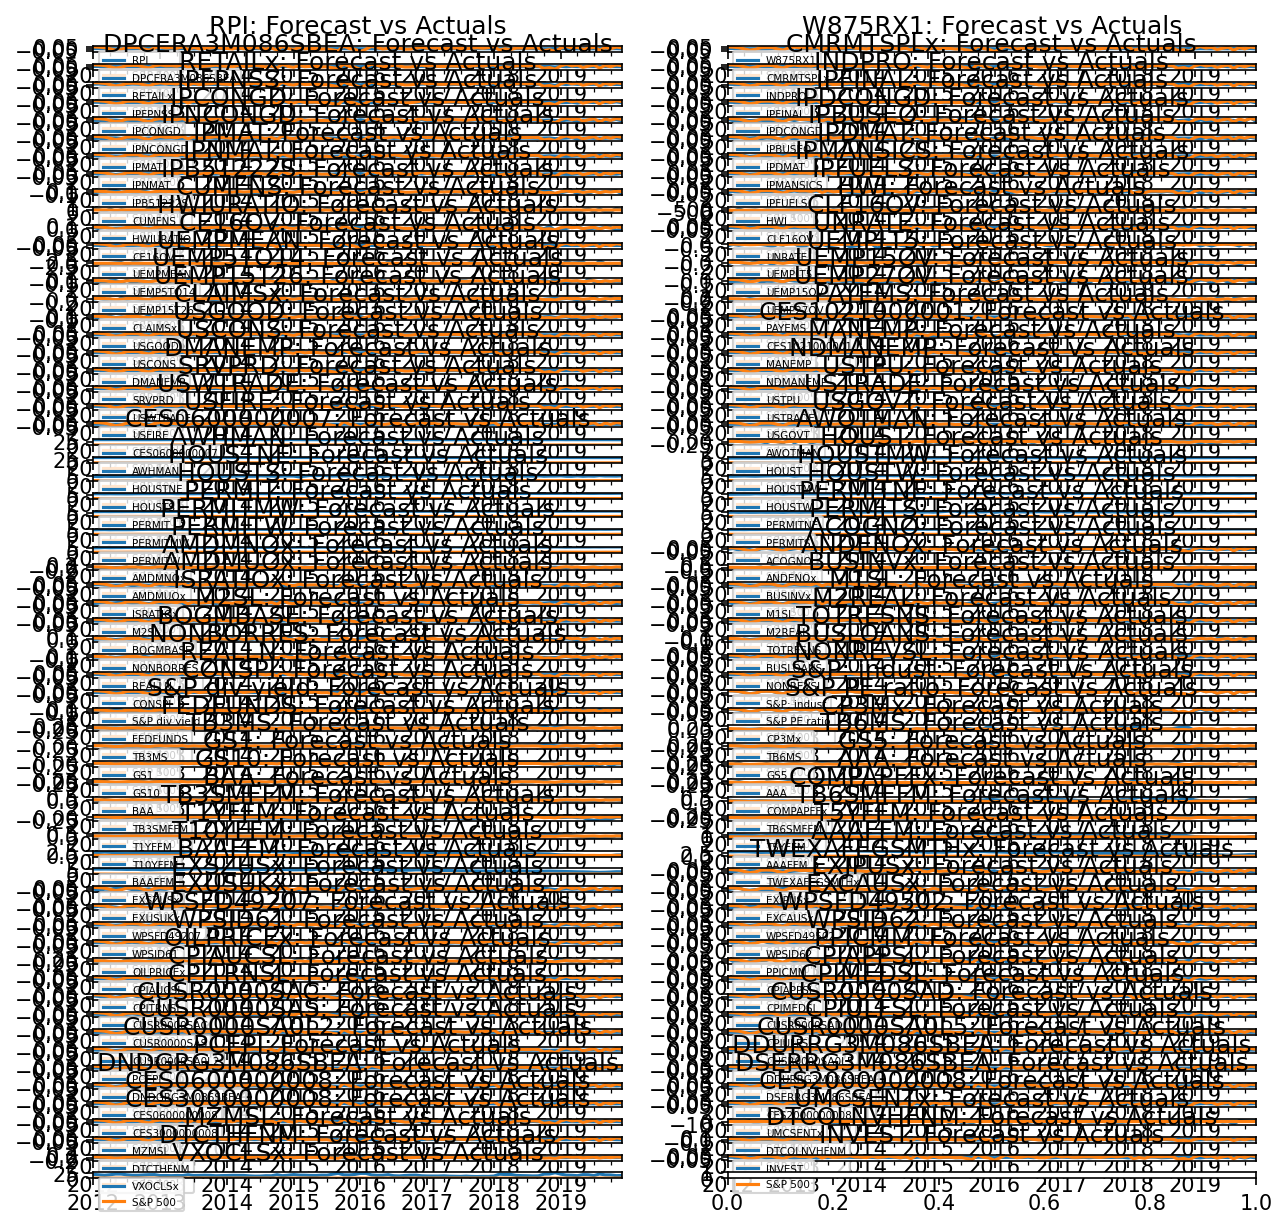

In [13]:
all_compare(df,compare = "S&P 500")#"EXJPUSx", "GS10", "WPSID61","CPITRNSL","CPIULFSL","CUSR0000SA0L2","PCEPI","DNDGRG3M086SBEA"


In [17]:
corr = ["S&P 500","PAYEMS","EXJPUSx", "GS10", "WPSID61","CPITRNSL","CPIULFSL","CUSR0000SA0L2","PCEPI","DNDGRG3M086SBEA"]
grangers_causation_matrix(df[corr].dropna(),variables = corr,set_p_value =0.01)

S&P 500_x PAYEMS_x EXJPUSx_x  GS10_x WPSID61_x CPITRNSL_x  \
S&P 500_y                 1   0.0023     False   False     False      False   
PAYEMS_y              False        1     False   False     False      False   
EXJPUSx_y             False    False         1   False     False      False   
GS10_y               0.0043    False     False       1     False      False   
WPSID61_y             False    False     False   False         1      False   
CPITRNSL_y           0.0002    False     False  0.0023    0.0018          1   
CPIULFSL_y            0.001    False     False  0.0043    0.0019      False   
CUSR0000SA0L2_y      0.0001    False     False  0.0024    0.0011      False   
PCEPI_y              0.0003    False     False  0.0046    0.0001          0   
DNDGRG3M086SBEA_y         0    False     False  0.0009    0.0002      False   

                  CPIULFSL_x CUSR0000SA0L2_x PCEPI_x DNDGRG3M086SBEA_x  
S&P 500_y              False           False   False             False  
PAYEMS_y               False           False   False             False  
EXJPUSx_y              False           False   False             False  
GS10_y                 False           False   False             False  
WPSID61_y              False           False   False             False  
CPITRNSL_y             False           False  0.0005             False  
CPIULFSL_y                 1           False  0.0019             False  
CUSR0000SA0L2_y        False               1       0             False  
PCEPI_y                    0               0       1            0.0009  
DNDGRG3M086SBEA_y      False           False   False                 1

In [7]:
selected_variables = []
for idx, val,ycol,yval in zip(data_matrix["S&P 500_x"].index,data_matrix["S&P 500_x"].values,data_matrix.loc["S&P 500_y"].index,data_matrix.loc["S&P 500_y"].values):
    if val != False and yval != False:
        selected_variables.append(idx[:-2])
print(selected_variables)

data_matrix.loc["S&P 500_y"]
# Extract variables' name, only if they affect S&P500
sp500_list = []
for col,val in data_matrix.loc["S&P 500_y"].items():
    if val != False:
        sp500_list.append(col[:-2])

['BUSLOANS', 'NONREVSL', 'S&P 500', 'GS5', 'OILPRICEx', 'CPIAPPSL', 'DTCOLNVHFNM', 'DTCTHFNM']


In [8]:
# check the causation of chosen variables in sp500_list
# to tell which variable is not affected by S&P500
data_matrix2 = grangers_causation_matrix(df[selected_variables].dropna(),variables = selected_variables,set_p_value =0.01)
data_matrix2

BUSLOANS_x NONREVSL_x  S&P 500_x   GS5_x OILPRICEx_x CPIAPPSL_x  \
BUSLOANS_y             1      False     0.0004   0.003       False     0.0017   
NONREVSL_y         False          1     0.0023   False      0.0002      False   
S&P 500_y         0.0004     0.0036     1.0000  0.0055      0.0004     0.0055   
GS5_y              False      False     0.0001       1       False      False   
OILPRICEx_y       0.0021      False     0.0075  0.0006           1      False   
CPIAPPSL_y        0.0073      False     0.0045   False       False          1   
DTCOLNVHFNM_y      False      False     0.0031   False      0.0001      False   
DTCTHFNM_y         False      False     0.0008   False      0.0002      False   

              DTCOLNVHFNM_x DTCTHFNM_x  
BUSLOANS_y            False      False  
NONREVSL_y            False      False  
S&P 500_y             0.001     0.0008  
GS5_y                 False      False  
OILPRICEx_y          0.0014     0.0042  
CPIAPPSL_y            False      False  
DTCOLNVHFNM_y             1      False  
DTCTHFNM_y            False          1

In [9]:
cointegration_test(USA[selected_variables[:]])

Name   ::  Test Stat > C(95.0%)    =>   Signif  
 ----------------------------------------
BUSLOANS ::  290.38    > 143.6691  =>   True
NONREVSL ::  187.8     > 111.7797  =>   True
S&P 500 ::  110.18    > 83.9383   =>   True
GS5    ::  63.15     > 60.0627   =>   True
OILPRICEx ::  39.34     > 40.1749   =>   False
CPIAPPSL ::  17.9      > 24.2761   =>   False
DTCOLNVHFNM ::  4.51      > 12.3212   =>   False
DTCTHFNM ::  0.14      > 4.1296    =>   False


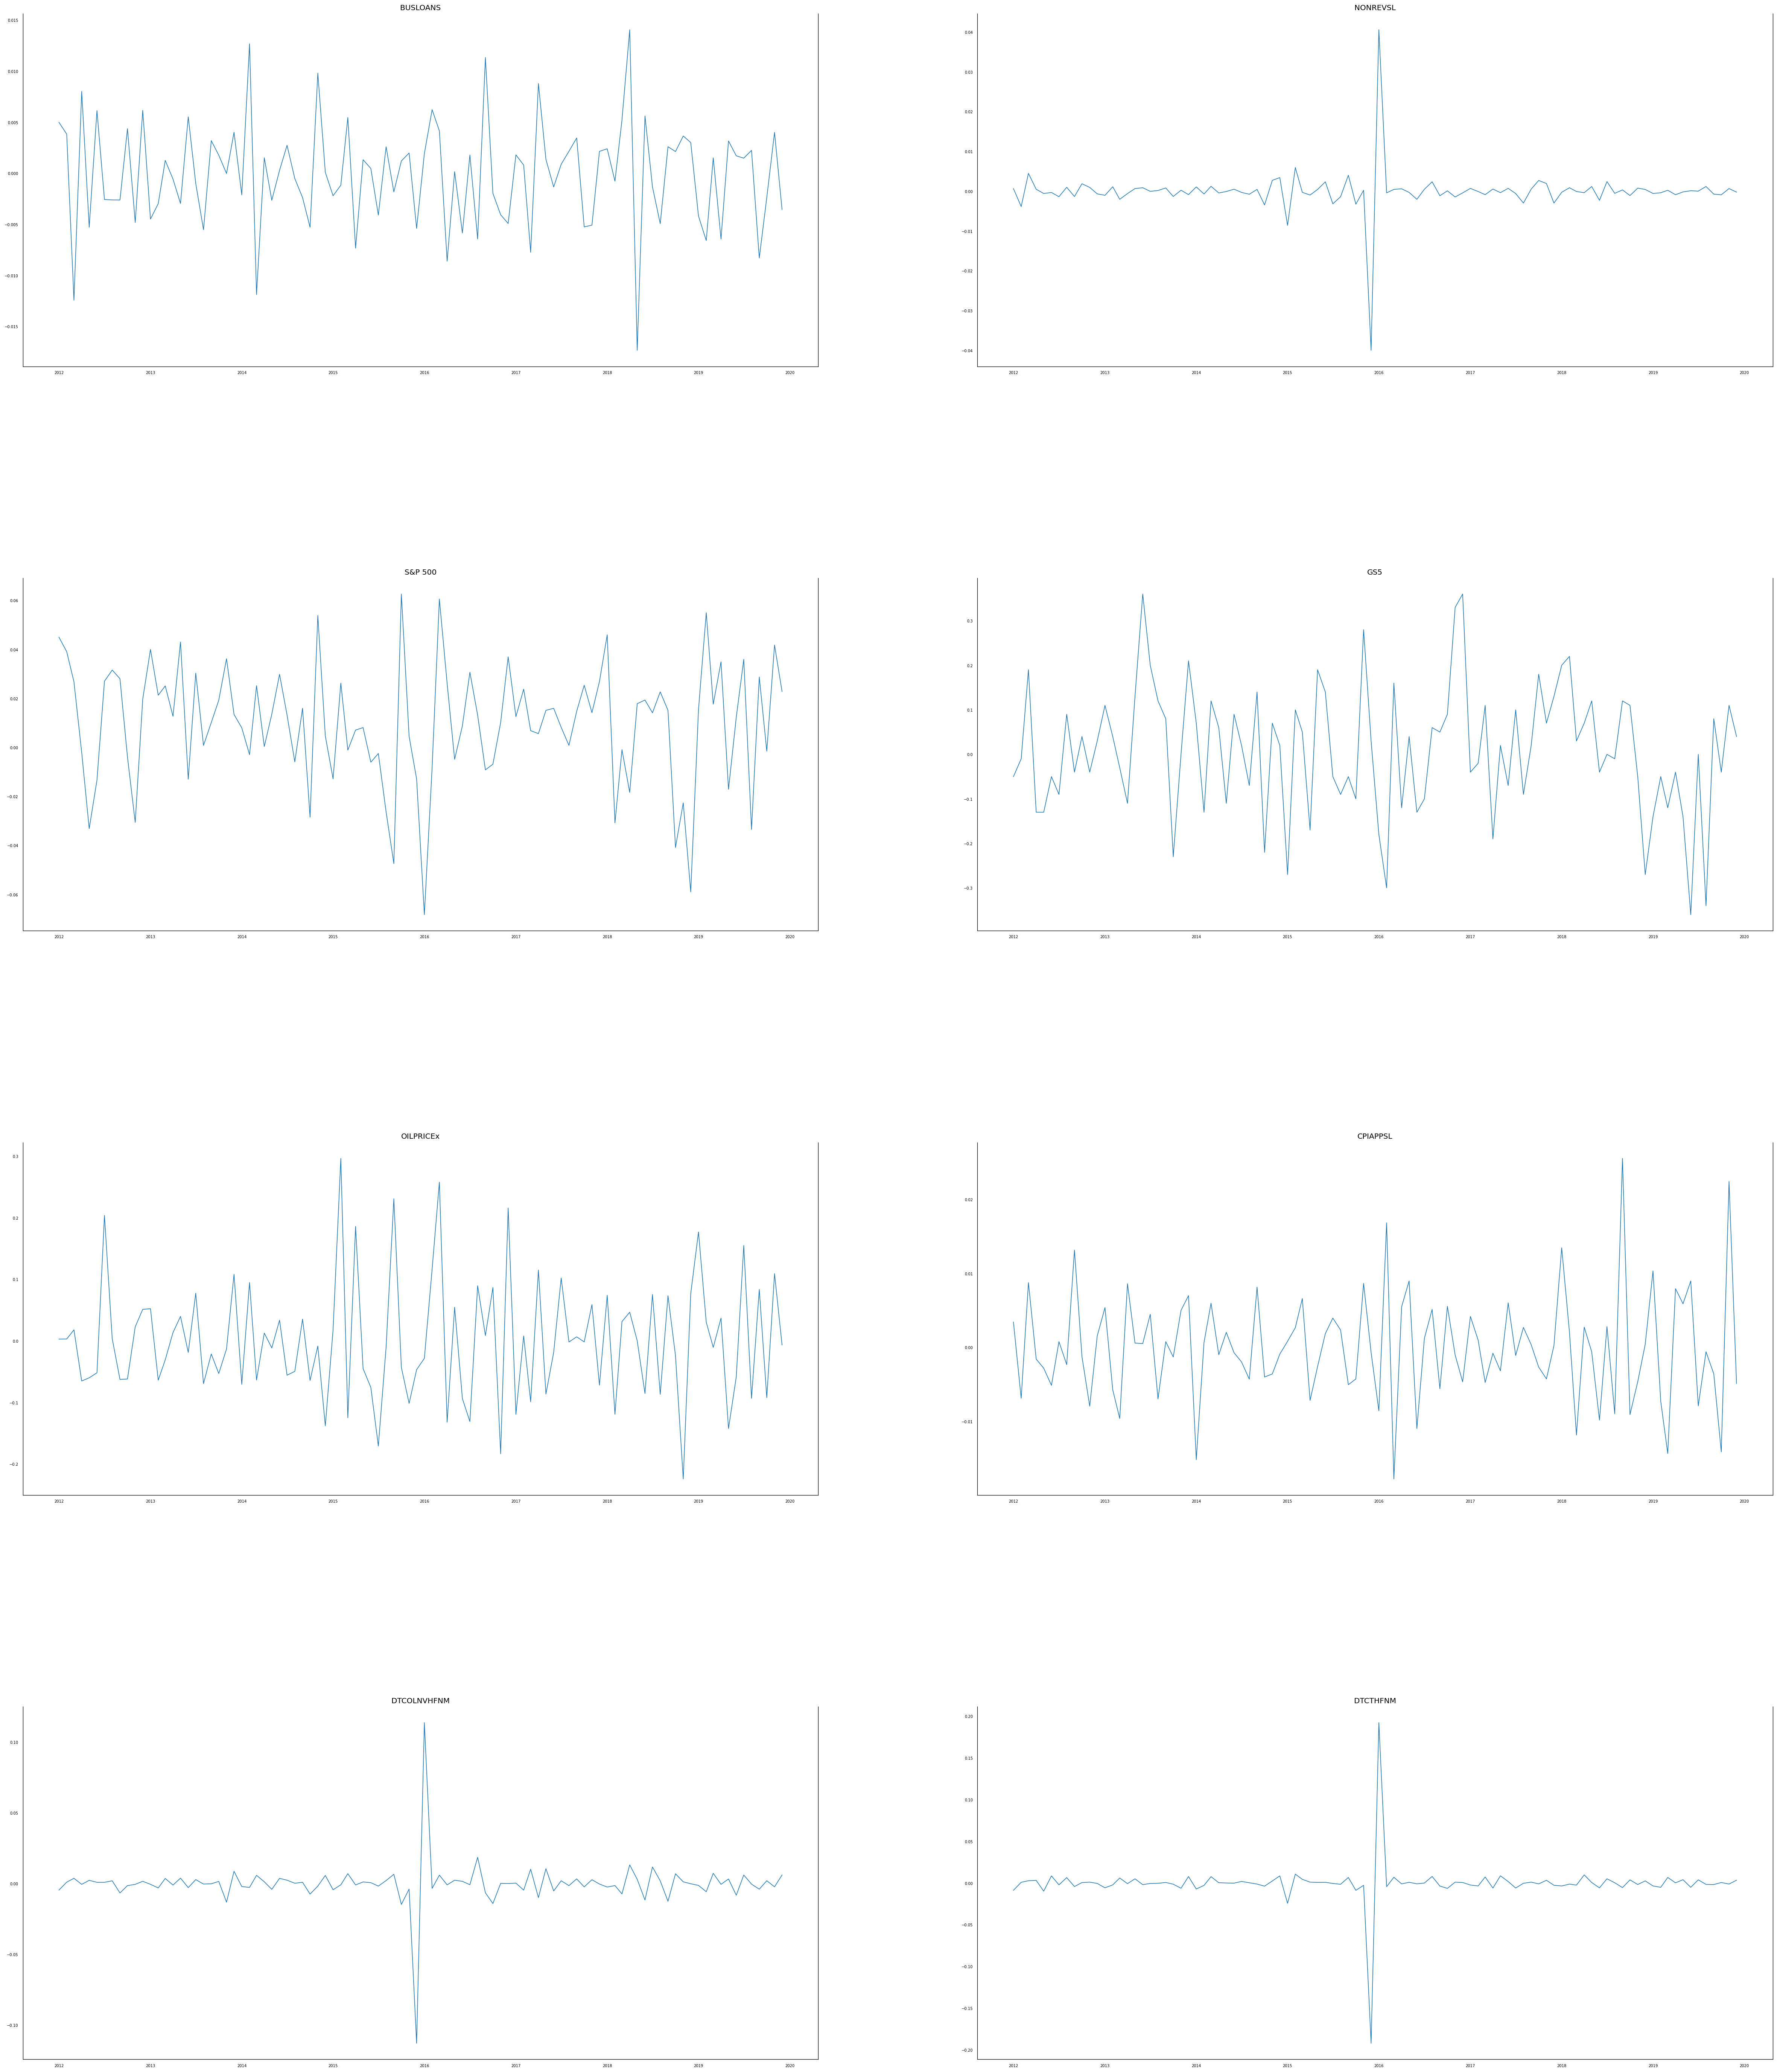

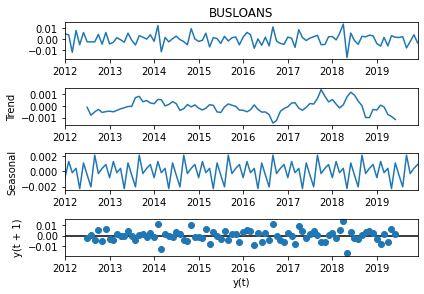

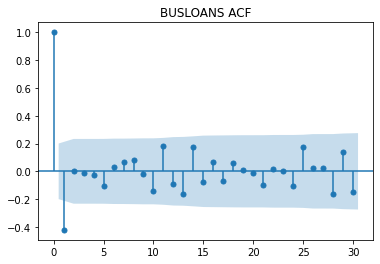

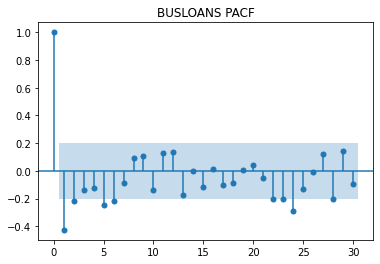

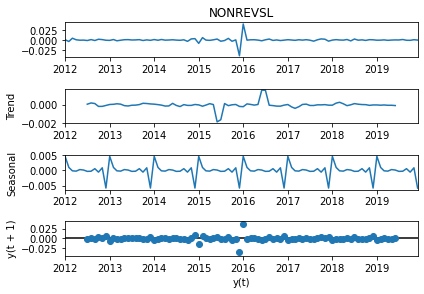

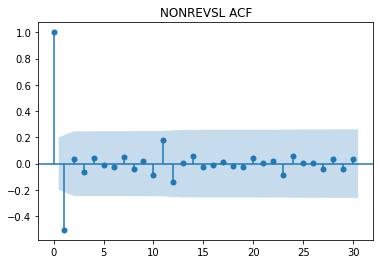

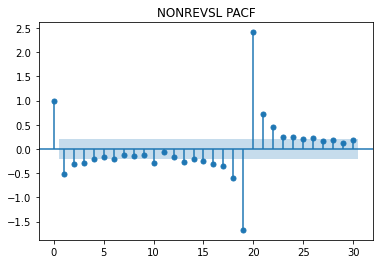

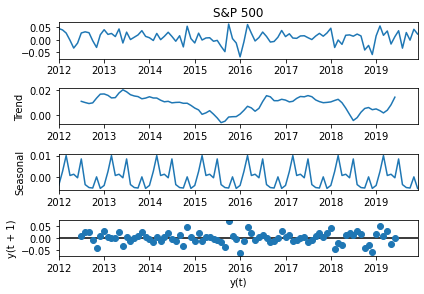

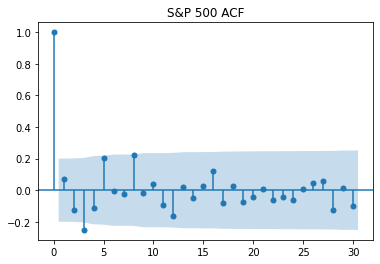

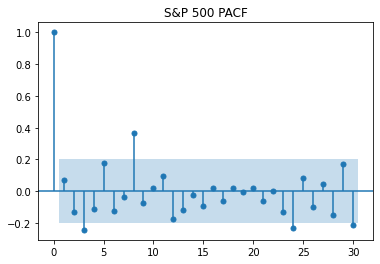

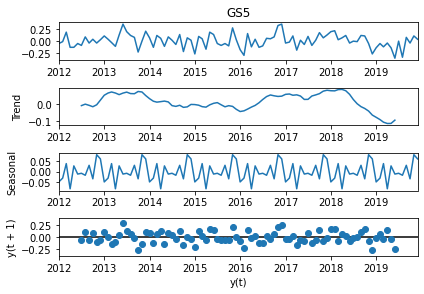

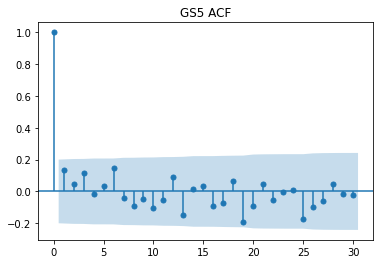

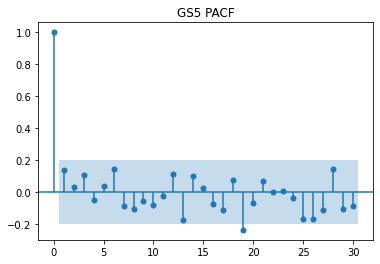

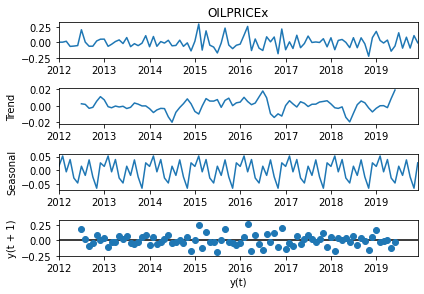

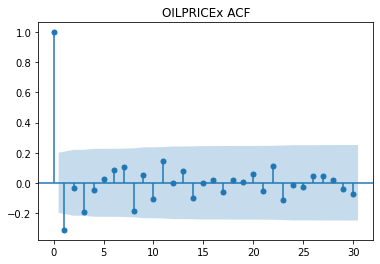

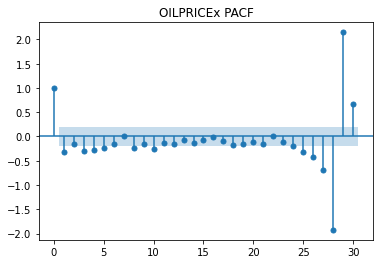

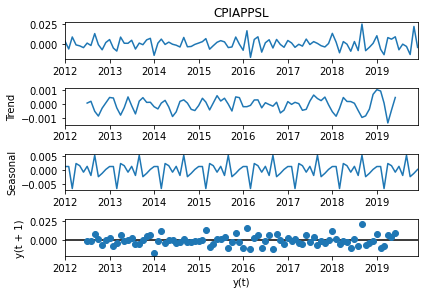

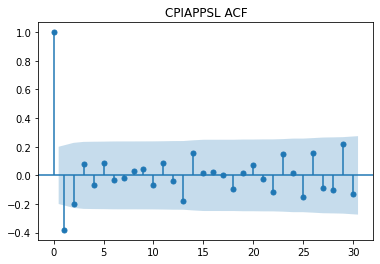

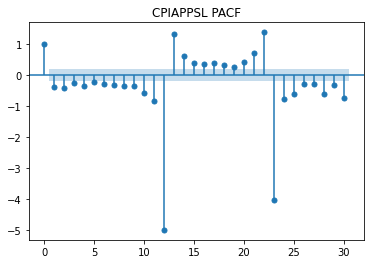

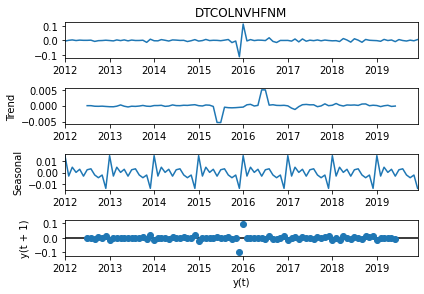

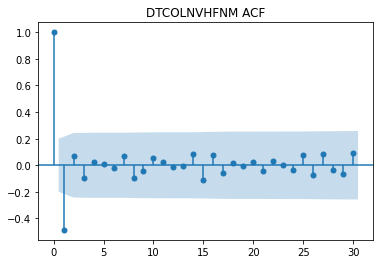

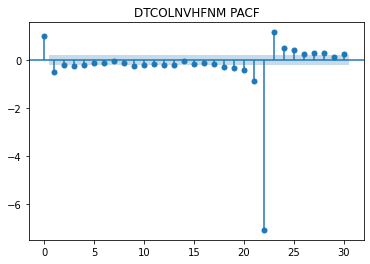

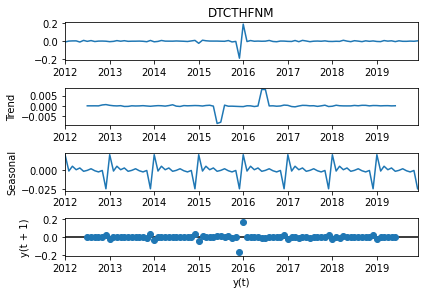

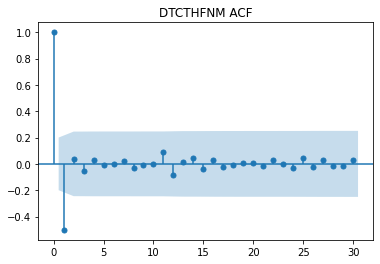

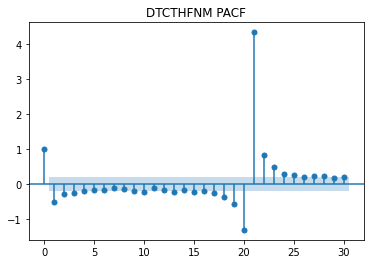

In [10]:
all_plot(df[selected_variables],season = True, acf = True,figsize = (50,60))
# どれもseasonalが発生していることがわかるので，m = 12でどこかで調整したい．

#### 変数選択
使えたのは"S_P500","GDP_growth","GCE","GDS","TRADE" 
共和分は"S_P500","GDP_growth","GCE","GDS" 



Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  197.28    > 121.7375  =>   True
INDPRO ::  117.63    > 92.7136   =>   True
USFIRE ::  75.94     > 67.6367   =>   True
PERMITNE ::  44.64     > 46.5716   =>   False
RETAILx ::  20.13     > 29.5147   =>   False
TOTRESNS ::  8.98      > 16.364    =>   False
GS1    ::  0.31      > 6.9406    =>   False
                               AR Model Results                               
Dep. Variable:                      R  -                  E                  T
Model:                          AR(2)   Log Likelihood                 299.336
Method:                          cmle   S.D. of innovations              0.006
Date:                Fri, 18 Dec 2020   AIC                            -10.041
Time:                        18:04:16   BIC                             -9.924
Sample:                    01-01-2012   HQIC                            -9.994
                         - 12-01-2018        

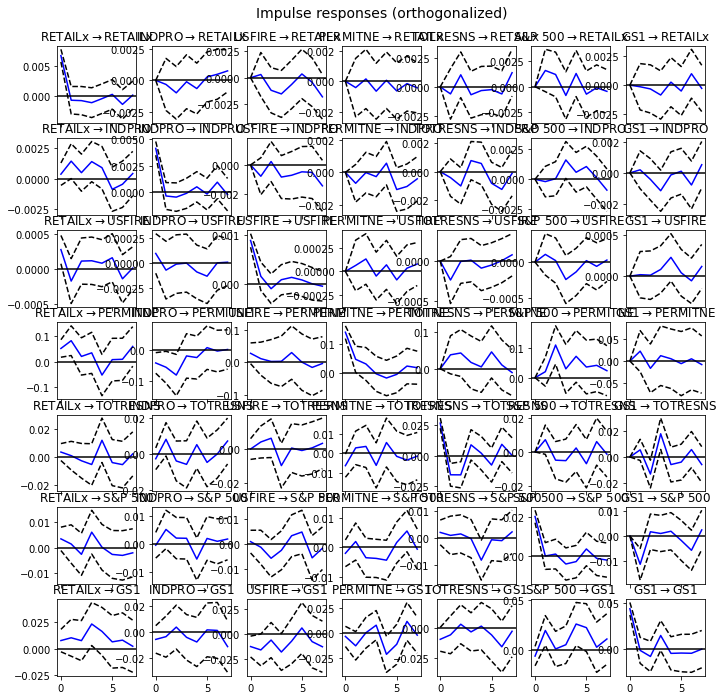

The function plots the Forecast Error Variance Decomposition
FEVD for RETAILx
       RETAILx    INDPRO    USFIRE  PERMITNE  TOTRESNS   S&P 500       GS1
0     1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1     0.934068  0.002126  0.001879  0.003423  0.007220  0.050870  0.000414
2     0.849673  0.019710  0.027312  0.003497  0.025846  0.071607  0.002355
3     0.787316  0.017993  0.063137  0.010016  0.030682  0.076717  0.014140
4     0.755108  0.023794  0.066639  0.009634  0.030861  0.099420  0.014544
5     0.738685  0.024301  0.067046  0.015486  0.030997  0.105276  0.018209
6     0.726963  0.026314  0.066133  0.014983  0.034562  0.099737  0.031308
7     0.671003  0.031748  0.104729  0.016249  0.051512  0.094796  0.029963
8     0.666315  0.031910  0.105392  0.016087  0.050850  0.095740  0.033705
9     0.652554  0.031221  0.120268  0.018450  0.051497  0.092843  0.033167
10    0.642379  0.032507  0.118307  0.018203  0.051391  0.101020  0.036193
11    0.636497  0.0369

{'RETAILx': 2,
 'INDPRO': 6,
 'USFIRE': 3,
 'PERMITNE': 2,
 'TOTRESNS': 5,
 'S&P 500': 3,
 'GS1': 3}

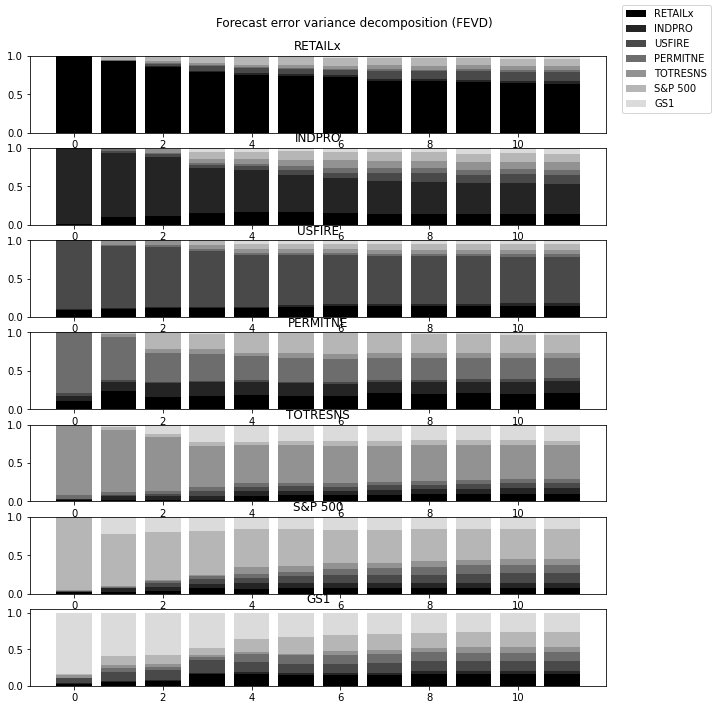

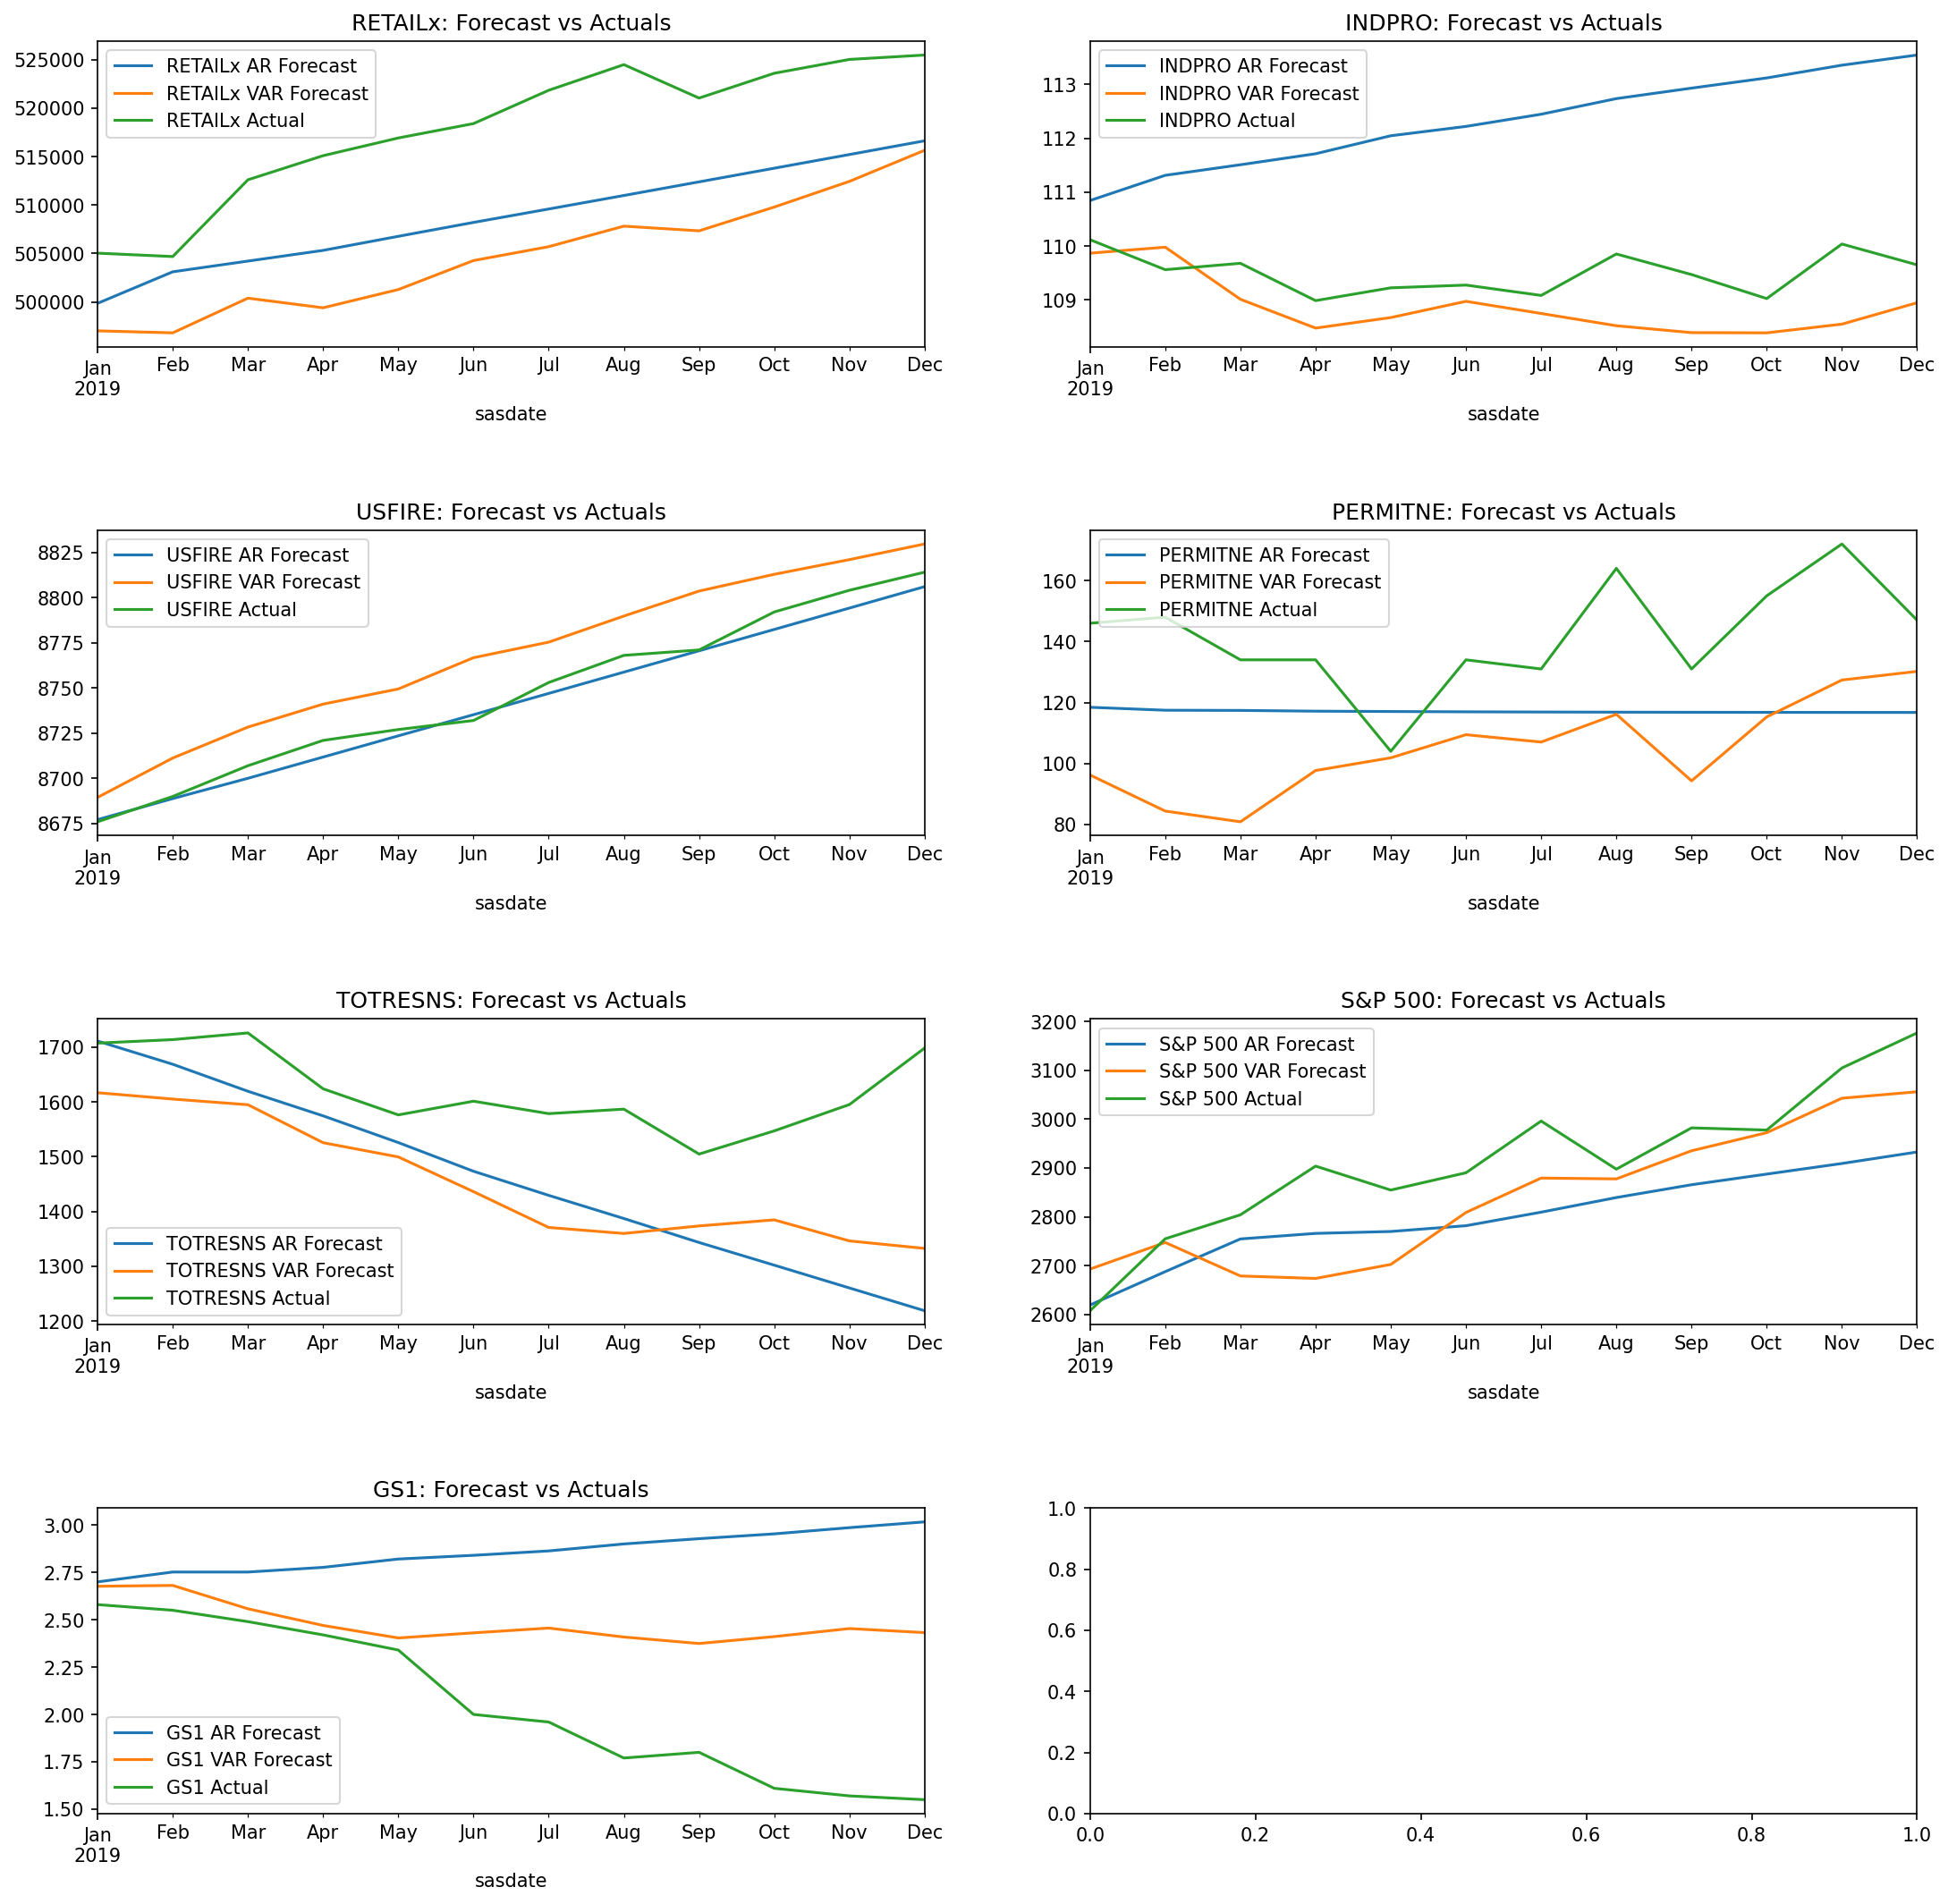

In [22]:
# Choose variables are included in the list named "ideal"
ideal = ["S&P 500","INDPRO","USFIRE","PERMITNE","RETAILx","TOTRESNS","GS1"] #"CES2000000008",
cointegration_test(USA[ideal],alpha = 0.01)
code_ideal = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in ideal}
evaluate_plot(USA[ideal],code_ideal,num=12)
#coin_evaluate_plot(USA[try_variables],code_ideal,num=12)

GS1 shows reletively have more effects on S P 500

In [23]:
# ideal = ["GS1","UMCSENTx"]
# code_ideal = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in ideal}
# a,c = ARmodel(df)
# b = revert_forecast(USA,a,transformation_code)

ideal = ["S&P 500","INDPRO","DSERRG3M086SBEA","TOTRESNS","CMRMTSPLx"] #"CES2000000008",
cointegration_test(USA[ideal],alpha = 0.01)
code_ideal = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in ideal}
#evaluate_plot(USA[ideal],code_ideal,num=12)
#coin_evaluate_plot(USA[try_variables],code_ideal,num=12)

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  71.55     > 67.6367   =>   True
INDPRO ::  34.25     > 46.5716   =>   False
DSERRG3M086SBEA ::  14.43     > 29.5147   =>   False
TOTRESNS ::  6.74      > 16.364    =>   False
CMRMTSPLx ::  0.14      > 6.9406    =>   False


In [26]:
ideal = ["S&P 500","IPMAT","CLAIMSx","PERMITNE","UMCSENTx","M2REAL","CP3Mx","OILPRICEx"] #"CES2000000008",
cointegration_test(USA[ideal],alpha = 0.01)
code_ideal = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in ideal}
#evaluate_plot(USA[ideal],code_ideal,num=12)
#coin_evaluate_plot(USA[try_variables],code_ideal,num=12)
#他になければCP3Mxを加えてもいい．

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  219.52    > 154.7977  =>   True
IPMAT  ::  160.57    > 121.7375  =>   True
CLAIMSx ::  106.68    > 92.7136   =>   True
PERMITNE ::  74.93     > 67.6367   =>   True
UMCSENTx ::  47.32     > 46.5716   =>   True
M2REAL ::  26.76     > 29.5147   =>   False
CP3Mx  ::  11.42     > 16.364    =>   False
OILPRICEx ::  0.52      > 6.9406    =>   False


In [27]:
ideal = ["S&P 500","CUMFNS","CES2000000008","BOGMBASE","GS5","PPICMM"] #"CES2000000008",
cointegration_test(USA[ideal],alpha = 0.01)
code_ideal = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in ideal}
#evaluate_plot(USA[ideal],code_ideal,num=12)
#coin_evaluate_plot(USA[try_variables],code_ideal,num=12)
#GS5は有効っぽい．

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  112.32    > 92.7136   =>   True
CUMFNS ::  66.4      > 67.6367   =>   False
CES2000000008 ::  34.9      > 46.5716   =>   False
BOGMBASE ::  19.24     > 29.5147   =>   False
GS5    ::  3.84      > 16.364    =>   False
PPICMM ::  0.02      > 6.9406    =>   False


In [28]:
ideal= ["S&P 500","NONBORRES","GS10","CPIAPPSL"] #"CES2000000008",
cointegration_test(USA[ideal],alpha = 0.01)
code_ideal = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in ideal}
#evaluate_plot(USA[ideal],code_ideal,num=12)
#coin_evaluate_plot(USA[try_variables],code_ideal,num=12)#NONBORRESで諦めるか？

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  40.77     > 46.5716   =>   False
NONBORRES ::  17.34     > 29.5147   =>   False
GS10   ::  5.58      > 16.364    =>   False
CPIAPPSL ::  0.4       > 6.9406    =>   False


In [29]:
ideal = ["S&P 500","DTCOLNVHFNM","DSERRG3M086SBEA"] #"CES2000000008",
cointegration_test(USA[ideal],alpha = 0.01)
code_ideal = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in ideal}
#evaluate_plot(USA[ideal],code_ideal,num=12)
#coin_evaluate_plot(USA[try_variables],code_ideal,num=12)# DTCOLNVHFNMはあり

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  23.99     > 29.5147   =>   False
DTCOLNVHFNM ::  5.14      > 16.364    =>   False
DSERRG3M086SBEA ::  0.07      > 6.9406    =>   False


In [30]:
ideal = ["S&P 500","DTCTHFNM"] #"CES2000000008",
cointegration_test(USA[ideal],alpha = 0.01)
code_ideal = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in ideal}
#evaluate_plot(USA[ideal],code_ideal,num=12)
#coin_evaluate_plot(USA[try_variables],code_ideal,num=12)

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  15.69     > 16.364    =>   False
DTCTHFNM ::  0.04      > 6.9406    =>   False


In [31]:
#重要 ここから下
ideal = ["S&P 500","DTCOLNVHFNM", "NONBORRES", "CMRMTSPLx", "INDPRO", "GS1"] # GS1ではrmse 75.001
cointegration_test(USA[ideal],alpha = 0.01)
code_ideal = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in ideal}
#evaluate_plot(USA[ideal],code_ideal,num=12)
#coin_evaluate_plot(USA[try_variables],code_ideal,num=12)

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  138.23    > 92.7136   =>   True
DTCOLNVHFNM ::  71.78     > 67.6367   =>   True
NONBORRES ::  42.78     > 46.5716   =>   False
CMRMTSPLx ::  23.24     > 29.5147   =>   False
INDPRO ::  9.25      > 16.364    =>   False
GS1    ::  0.32      > 6.9406    =>   False


In [32]:
ideal = ["CMRMTSPLx","GS5","INDPRO","S&P 500"] # GS1ではrmse 75.001
cointegration_test(USA[ideal],alpha = 0.01)
code_ideal = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in ideal}
#evaluate_plot(USA[ideal],code_ideal,num=12)
#coin_evaluate_plot(USA[try_variables],code_ideal,num=12)

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
CMRMTSPLx ::  36.32     > 46.5716   =>   False
GS5    ::  12.58     > 29.5147   =>   False
INDPRO ::  2.79      > 16.364    =>   False
S&P 500 ::  0.7       > 6.9406    =>   False


In [ ]:
keys = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key != "S&P 500"}
for key in keys:
    cointegration_test(USA[["S&P 500",key]].dropna())

In [ ]:
estimate_cointegration = ["S&P 500","IPDCONGD", "HOUSTS", "PERMITNE", "CONSPI", "GS5", "COMPAPFFx","TB3SMFFM", "TB6SMFFM", "T1YFFM", "VXOCLSx"]
keys = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in estimate_cointegration}
cointegration_test(USA[estimate_cointegration].dropna())

In [ ]:
variables = ["S&P 500","IPDCONGD", "HOUSTS", "PERMITNE", "CONSPI", "GS5", "COMPAPFFx","TB3SMFFM"]
keys = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in variables}
coin_evaluate_plot(USA[variables],keys)

In [ ]:
# omit some variables which did not show enough effects on S&P 500
variables = ["S&P 500","IPDCONGD", "PERMITNE", "CONSPI", "GS5", "COMPAPFFx"]
keys = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in variables}
coin_evaluate_plot(USA[variables],keys,order = 10)

In [ ]:
variables = ["S&P 500","GS5", "COMPAPFFx"]
keys = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in variables}
coin_evaluate_plot(USA[variables],keys,order = 10)

As you can easily see, many data contains seasonality. Thus I expected cointegrated variables perform better.
However, they didn't.
What is clear now is that ["S&P 500","DTCOLNVHFNM", "NONBORRES", "CMRMTSPLx", "INDPRO", "GS5"]　performed better.


In [ ]:
represent_omit = ["S&P 500","DTCOLNVHFNM", "CMRMTSPLx", "INDPRO", "GS1"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in represent_omit}
evaluate_plot(USA[represent_omit],code_rep,num=12)

In [ ]:
represent_omit2 = ["S&P 500", "CMRMTSPLx", "INDPRO"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in represent_omit2}
evaluate_plot(USA[represent_omit2],code_rep,num=12)

In [ ]:
transformation_code["NONBORRES"]

In [46]:
represent3 = ["S&P 500","OILPRICEx","M2REAL","PERMITNE","GS10"]#,"CES2000000008","COMPAPFFx","INDPRO"]
cointegration_test(USA[represent3].dropna())

Name   ::  Test Stat > C(95.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  59.07     > 60.0627   =>   False
OILPRICEx ::  32.86     > 40.1749   =>   False
M2REAL ::  16.21     > 24.2761   =>   False
PERMITNE ::  5.42      > 12.3212   =>   False
GS10   ::  0.15      > 4.1296    =>   False


Name   ::  Test Stat > C(95.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  59.07     > 60.0627   =>   False
OILPRICEx ::  32.86     > 40.1749   =>   False
M2REAL ::  16.21     > 24.2761   =>   False
PERMITNE ::  5.42      > 12.3212   =>   False
GS10   ::  0.15      > 4.1296    =>   False
                               AR Model Results                               
Dep. Variable:                      P  -                  E                  R
Model:                          AR(2)   Log Likelihood                  21.707
Method:                          cmle   S.D. of innovations              0.186
Date:                Wed, 09 Dec 2020   AIC                             -3.270
Time:                        23:15:08   BIC                             -3.152
Sample:                    01-01-2012   HQIC                            -3.223
                         - 12-01-2018                                         
                  coef    std err          z      P

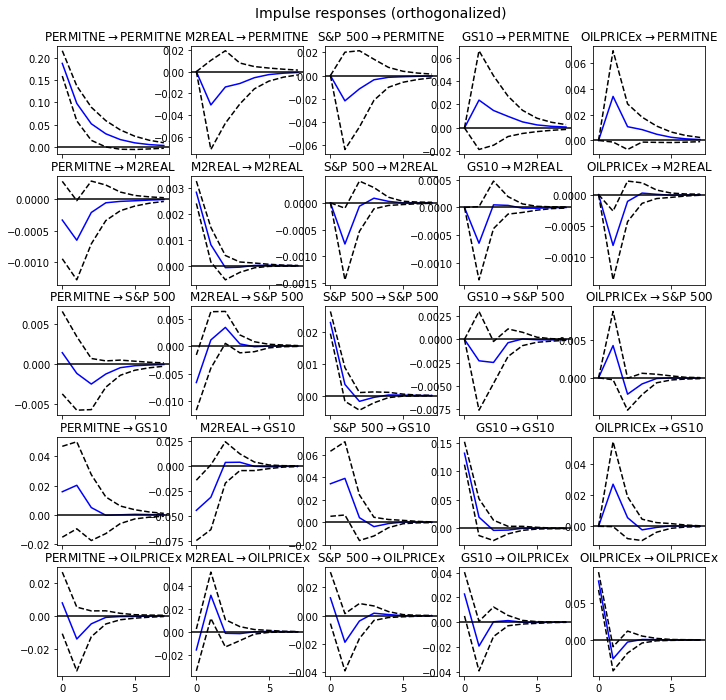

The function plots the Forecast Error Variance Decomposition
FEVD for PERMITNE
      PERMITNE    M2REAL   S&P 500      GS10  OILPRICEx
0     1.000000  0.000000  0.000000  0.000000   0.000000
1     0.935028  0.019295  0.009805  0.011667   0.024205
2     0.926355  0.021884  0.011713  0.015195   0.024852
3     0.922274  0.023649  0.011712  0.016708   0.025657
4     0.921200  0.024084  0.011681  0.017098   0.025937
5     0.920941  0.024181  0.011681  0.017190   0.026007
6     0.920868  0.024208  0.011683  0.017217   0.026024
7     0.920846  0.024216  0.011684  0.017225   0.026030
8     0.920839  0.024219  0.011684  0.017227   0.026031
9     0.920837  0.024220  0.011684  0.017228   0.026032
10    0.920837  0.024220  0.011684  0.017228   0.026032
11    0.920836  0.024220  0.011684  0.017228   0.026032

FEVD for M2REAL
      PERMITNE    M2REAL   S&P 500      GS10  OILPRICEx
0     0.013466  0.986534  0.000000  0.000000   0.000000
1     0.048942  0.799681  0.053802  0.037965   0.059609
2     0.

{'PERMITNE': 2, 'M2REAL': 1, 'S&P 500': 3, 'GS10': 1, 'OILPRICEx': 4}

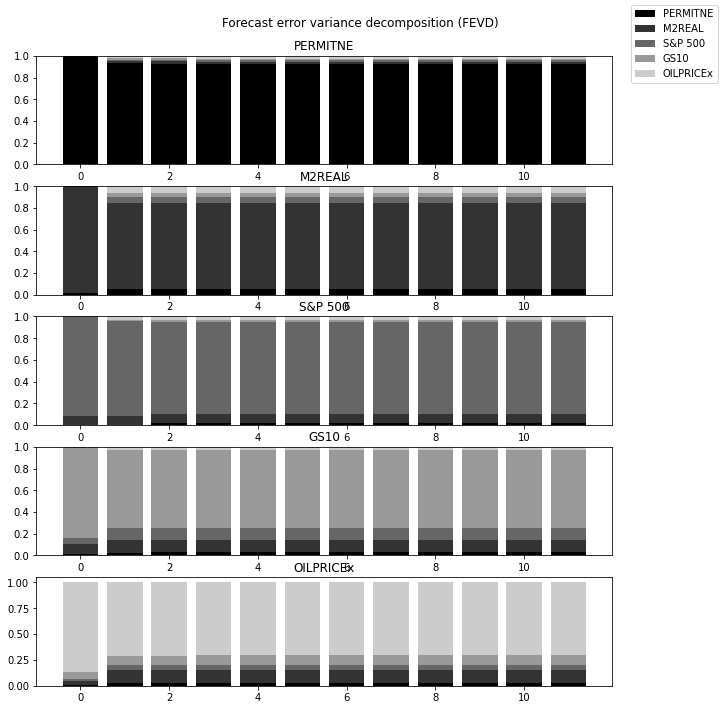

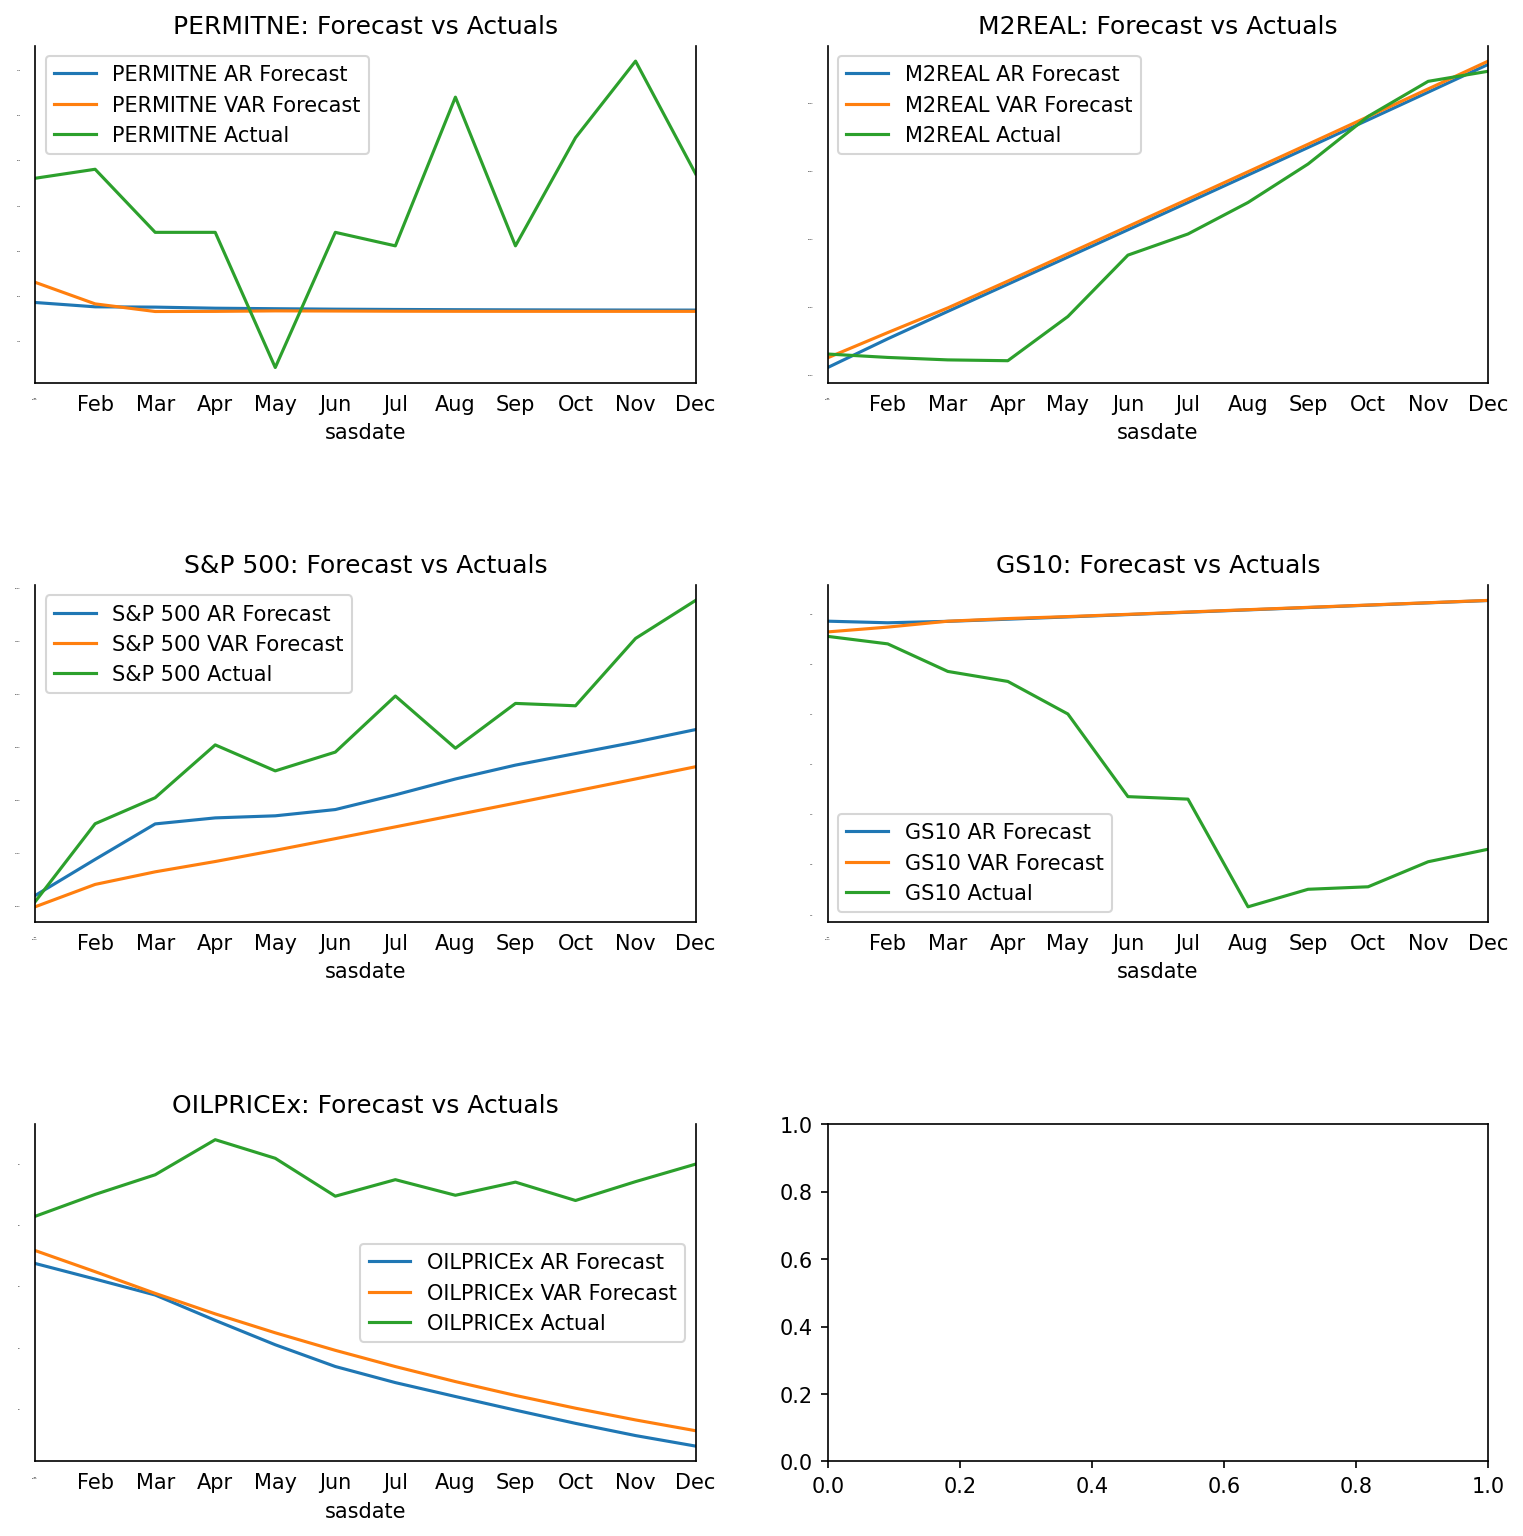

In [45]:
represent3=["S&P 500","OILPRICEx","M2REAL","PERMITNE","GS10"]
cointegration_test(USA[represent3].dropna())
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in represent3}
evaluate_plot(USA[represent3],code_rep,num=12,order = 10)

Name   ::  Test Stat > C(95.0%)    =>   Signif  
 ----------------------------------------
OILPRICEx ::  31.99     > 40.1749   =>   False
M2REAL ::  13.7      > 24.2761   =>   False
GS10   ::  5.44      > 12.3212   =>   False
S&P 500 ::  2.0       > 4.1296    =>   False
                               AR Model Results                               
Dep. Variable:                      M  -                  2                  R
Model:                          AR(1)   Log Likelihood                 361.707
Method:                          cmle   S.D. of innovations              0.003
Date:                Wed, 09 Dec 2020   AIC                            -11.481
Time:                        23:14:11   BIC                            -11.394
Sample:                    01-01-2012   HQIC                           -11.446
                         - 12-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------

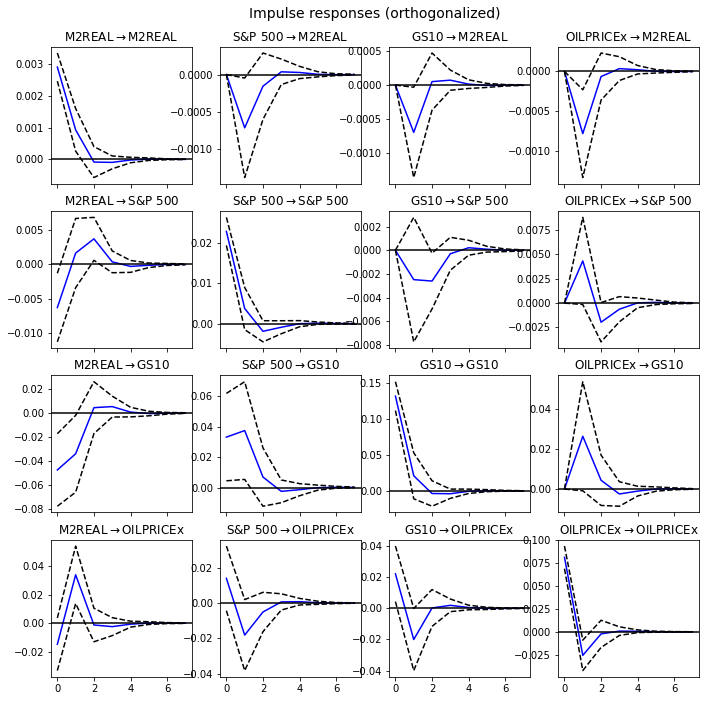

The function plots the Forecast Error Variance Decomposition
FEVD for M2REAL
        M2REAL   S&P 500      GS10  OILPRICEx
0     1.000000  0.000000  0.000000   0.000000
1     0.851826  0.047322  0.044133   0.056719
2     0.849463  0.049412  0.044219   0.056907
3     0.848975  0.049458  0.044634   0.056933
4     0.848871  0.049520  0.044646   0.056963
5     0.848870  0.049521  0.044648   0.056962
6     0.848868  0.049521  0.044648   0.056963
7     0.848868  0.049521  0.044648   0.056963
8     0.848868  0.049521  0.044648   0.056963
9     0.848868  0.049521  0.044648   0.056963
10    0.848868  0.049521  0.044648   0.056963
11    0.848868  0.049521  0.044648   0.056963

FEVD for S&P 500
        M2REAL   S&P 500      GS10  OILPRICEx
0     0.070497  0.929503  0.000000   0.000000
1     0.070230  0.888582  0.010192   0.030997
2     0.089256  0.854599  0.020455   0.035690
3     0.089285  0.853939  0.020545   0.036231
4     0.089393  0.853768  0.020614   0.036225
5     0.089411  0.853731  0.020

{'M2REAL': 1, 'S&P 500': 3, 'GS10': 1, 'OILPRICEx': 4}

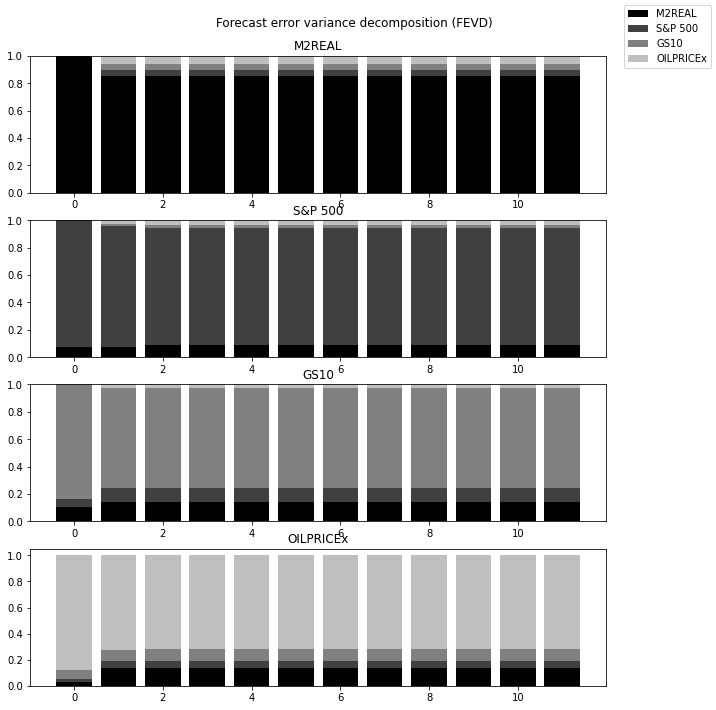

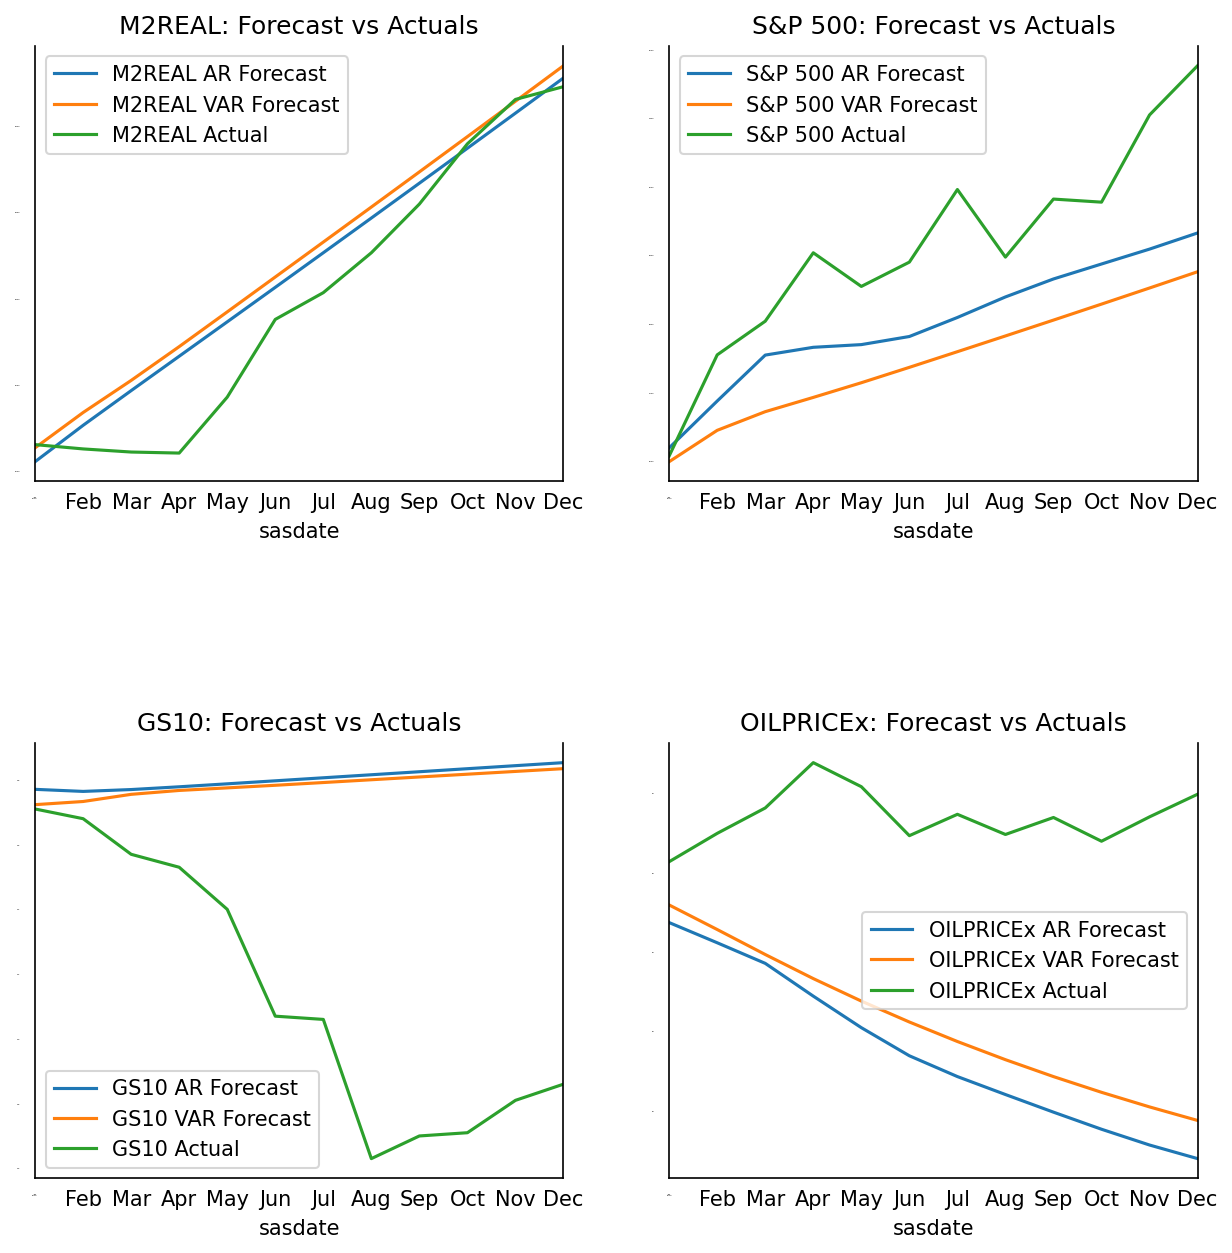

In [42]:
represent3=["OILPRICEx","M2REAL","GS10","S&P 500"]
cointegration_test(USA[represent3].dropna())
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in represent3}
evaluate_plot(USA[represent3],code_rep,num=12,order = 10)

In [ ]:
USA.columns

Group 1: IPFPNSS: .27 ，

Group 2: HWI:.21 , HWIURATIO: 0.3 , UEMP5T014: -.34

Group 3: HOUSTS: -0.52

Group 4: DPCERA3M086SBEA:.41 , CMRMTSPLx:-0.34, ACOGNO 0.41 ，SRATIOx: -.38 

Group 5: M2REAL -0.24, 

Group 6:　GS5:0.38

Group 7:　WPSFD49207: 0.48，WPSFD49502: 0.31，　WPSID61 0.4，OILPRICEx:0.31，CPITRNSL:0.41，CUSR000SAC: 0.3

In [ ]:
try_variables = ["RPI","HWI", "HOUST", "DPCERA3M086SBEA", "M1SL","FEDFUNDS","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["W875RX1","HWIURATIO", "HOUSTNE", "CMRMTSPLx", "M2SL","CP3Mx","WPSFD49502","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["INDPRO","CLF16OV", "HOUSTMW", "RETAILx", "M2REAL","TB3MS","WPSID61","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","CE16OV", "HOUSTS","ACOGNO", "BOGMBASE","TB6MS","WPSID62","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPCONGD","UEMPMEAN", "HOUSTW", "AMDMNOx", "TOTRESNS","GS1","OILPRICEx","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPDCONGD","UEMPLT5", "PERMIT", "ANDENOx", "NONBORRES","GS5","PPICMM","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPNCONGD","UEMP5TO14", "PERMITNE", "AMDMUOx", "CONSPI","GS10","CPIAUCSL","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPBUSEQ","UEMP15OV", "PERMITMW", "BUSINVx", "MZMSL","AAA","CPIAPPSL","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPMAT","UEMP15T26", "PERMITS", "ISRATIOx", "DTCOLNVHFNM","BAA","CPITRNSL","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPDMAT","UEMP27OV", "PERMITW", "UMCSENTx", "INVEST","TB3SMFFM","CUSR0000SAC","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPNMAT","CLAIMSx", "HOUSTS", "ACOGNO", "M2REAL","TB6SMFFM","CUSR0000SAS","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPMANSICS","PAYEMS", "HOUSTS", "ACOGNO", "M2REAL","T1YFFM","CPIULFSL","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFUELS","USGOOD", "HOUSTS", "ACOGNO", "M2REAL","T5YFFM","CUSR0000SA0L5","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["CUMFNS","CES1021000001", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","PCEPI","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","CES1021000001", "HOUSTS", "ACOGNO", "M2REAL","AAAFFM","DDURRG3M086SBEA","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","USCONS", "HOUSTS", "ACOGNO", "M2REAL","BAAFFM","DNDGRG3M086SBEA","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","MANEMP", "HOUSTS", "ACOGNO", "M2REAL","TWEXAFEGSMTHx","DSERRG3M086SBEA","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","DMANEMP", "HOUSTS", "ACOGNO", "M2REAL","EXSZUSx","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","NDMANEMP", "HOUSTS", "ACOGNO", "M2REAL","EXJPUSx","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","SRVPRD", "HOUSTS", "ACOGNO", "M2REAL","EXUSUKx","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","USTPU", "HOUSTS", "ACOGNO", "M2REAL","EXCAUSx","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","USWTRADE", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","USTRADE", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","USTRADE", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","USFIRE", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","USGOVT", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","CES0600000007", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","AWOTMAN", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","AWHMAN", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","CES0600000008", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","CES2000000008", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["IPFPNSS","CES3000000008", "HOUSTS", "ACOGNO", "M2REAL","T10YFFM","WPSFD49207","S&P 500"] # GS1ではrmse 75.001
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["S&P 500","IPFPNSS","USGOOD","HOUST","ACOGNO","M2REAL","T10YFFM","CPIAPPSL"]
cointegration_test(USA[try_variables].dropna())

In [ ]:
try_variables = ["S&P 500","IPFPNSS","USGOOD","HOUST","ACOGNO","M2REAL","T10YFFM","CPIAPPSL"]
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
coin_evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["S&P 500","CLAIMSx","ISRATIOx","M2REAL"]
group1 = ["IPFPNSS","IPMANSICS"]
group2 = ["HWI","HWIURATIO","UEMP5TO14","CLAIMSx","USGOOD","USFIRE","AWOTMAN"]
group3 = ["HOUSTS"]
group4 = ["DPCERA3M086SBEA", "CMRMTSPLx", "ACOGNO","ISRATIOx"]
group5 = ["M2REAL"]
group6 = ["GS5","T1YFFM", "T5YFFM", "T10YFFM", "AAAFFM", "EXJPUSx"]
group7 = ["WPSFD49207","WPSFD49502","CPIULFSL", "DNDGRG3M086SBEA","WPSID61","OILPRICEx","CPITRNSL","CUSR0000SAC"]

for i in group1:
    cointegration_test(USA[["S&P 500",i]])
for i in group2:
    cointegration_test(USA[["S&P 500",i]])
for i in group3:
    cointegration_test(USA[["S&P 500",i]])
for i in group4:
    cointegration_test(USA[["S&P 500",i]])
for i in group5:
    cointegration_test(USA[["S&P 500",i]])
for i in group6:
    cointegration_test(USA[["S&P 500",i]])
for i in group7:
    cointegration_test(USA[["S&P 500",i]])

In [ ]:
try_variables = ["S&P 500","HOUSTS","GS5","T1YFFM"]
cointegration_test(USA[try_variables])
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
coin_evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["S&P 500","GS5","T1YFFM"] #,"HOUSTS",
cointegration_test(USA[try_variables])
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
coin_evaluate_plot(USA[try_variables],code_rep,num=12)

In [ ]:
try_variables = ["S&P 500","GS5","T1YFFM"] #,"HOUSTS","GS5",T1YFFM
cointegration_test(USA[try_variables])

In [ ]:
# group8 = ["S&P 500"]
# group1 = ["RPI","IPFPNSS"]
# group2 = ["UNRATE","PAYEMS","CES3000000008"]
# group3 = ["HOUSTS"]
# group4 = ["DPCERA3M086SBEA" , "BUSINVx" , "M2REAL", "BOGMBASE"]
# group5 = ["TOTRESNS", "BUSLOANS"]
# group6 = ["GS1","GS5","GS10","AAA","BAA","T1YFFM","T5YFFM","T10YFFM"]
# group7 = ["WPSFD49207", "WPSID62", "CPIAUCSL"]
# for column2 in group2:
#     for column4 in group4:
#         for column5 in group5:
#             for column6 in group6:
#                 for column7 in group7:
#                     cointegration_test(USA[["S&P 500","RPI",column2,"HOUSTS",column4,column5,column6,column7]],alpha = 0.01)

In [ ]:
cointegration_test(USA[["S&P 500","RPI", "UNRATE", "HOUSTS", "DPCERA3M086SBEA", "BUSLOANS", "BAA", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "UNRATE", "HOUSTS", "DPCERA3M086SBEA", "BUSLOANS", "BAA", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "UNRATE", "HOUSTS", "BUSINVx", "TOTRESNS", "GS1", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "UNRATE", "HOUSTS", "BUSINVx", "TOTRESNS", "BAA", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "UNRATE", "HOUSTS", "BUSINVx", "BUSLOANS", "BAA", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "DPCERA3M086SBEA",  "TOTRESNS", "GS1", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "DPCERA3M086SBEA",  "TOTRESNS", "GS1", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "DPCERA3M086SBEA",  "BUSLOANS", "GS1", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "DPCERA3M086SBEA",  "BUSLOANS", "GS1", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "BUSINVx", "TOTRESNS", "GS1", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "BUSINVx", "BUSLOANS", "GS1", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "BUSINVx", "BUSLOANS", "GS1", "WPSID62"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "BUSINVx", "BUSLOANS", "GS1", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "M2REAL", "TOTRESNS", "GS1", "WPSID62"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "M2REAL", "TOTRESNS", "GS1", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "BOGMBASE", "BUSLOANS", "GS1", "WPSID62"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "BOGMBASE", "BUSLOANS", "GS1", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "BOGMBASE", "BUSLOANS", "GS1", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "BOGMBASE", "BUSLOANS", "AAA", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "BOGMBASE", "BUSLOANS", "T1YFFM", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","RPI", "CES3000000008", "HOUSTS", "BOGMBASE", "BUSLOANS", "T1YFFM", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","IPFPNSS", "PAYEMS", "HOUSTS", "M2REAL", "BUSLOANS", "GS1", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","IPFPNSS", "PAYEMS", "HOUSTS", "BOGMBASE","BUSLOANS", "GS1", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","IPFPNSS", "CES3000000008", "HOUSTS", "M2REAL", "BUSLOANS", "GS1", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","IPFPNSS", "CES3000000008", "HOUSTS", "M2REAL", "BUSLOANS", "GS1", "WPSID62"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","IPFPNSS", "CES3000000008", "HOUSTS", "M2REAL", "BUSLOANS", "GS1", "WPSID62"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","IPFPNSS", "CES3000000008", "HOUSTS", "M2REAL", "BUSLOANS", "GS1", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","IPFPNSS", "CES3000000008", "HOUSTS", "BOGMBASE", "TOTRESNS", "GS1", "WPSID62"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","IPFPNSS", "CES3000000008", "HOUSTS", "BOGMBASE", "TOTRESNS", "GS1", "CPIAUCSL"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","IPFPNSS", "CES3000000008", "HOUSTS", "BOGMBASE", "BUSLOANS", "GS1", "WPSFD49207"]],alpha = 0.01)
cointegration_test(USA[["S&P 500","IPFPNSS", "CES3000000008", "HOUSTS", "BOGMBASE", "BUSLOANS", "GS1", "WPSID62"]],alpha = 0.01)

In [ ]:
cointegration_test(USA[["S&P 500", "UNRATE","GS1", "HOUSTS", "BUSINVx", "TOTRESNS"]],alpha = 0.01)

In [33]:
try_variables = ["S&P 500", "UNRATE","GS1", "HOUSTS"]
cointegration_test(USA[try_variables])
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
#coin_evaluate_plot(USA[try_variables],code_rep,num=12)

Name   ::  Test Stat > C(95.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  77.97     > 40.1749   =>   True
UNRATE ::  30.71     > 24.2761   =>   True
GS1    ::  11.22     > 12.3212   =>   False
HOUSTS ::  2.97      > 4.1296    =>   False


In [34]:
try_variables = ["S&P 500", "UNRATE","GS1", "HOUSTS", "BUSINVx", "TOTRESNS"]
cointegration_test(USA[try_variables])
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
#evaluate_plot(USA[try_variables],code_rep,num=12)

Name   ::  Test Stat > C(95.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  125.98    > 83.9383   =>   True
UNRATE ::  79.03     > 60.0627   =>   True
GS1    ::  48.19     > 40.1749   =>   True
HOUSTS ::  25.02     > 24.2761   =>   True
BUSINVx ::  10.78     > 12.3212   =>   False
TOTRESNS ::  0.02      > 4.1296    =>   False


In [35]:
granger_list = ["S&P 500", "CUMFNS", "GS5", "CLAIMSx", "USFIRE", "BUSLOANS", "M2REAL","TOTRESNS", "INDPRO"]
grangers_causation_matrix(df[granger_list].dropna(),variables=granger_list)
cointegration_test(USA[granger_list],alpha = 0.01)

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  360.28    > 191.8122  =>   True
CUMFNS ::  256.09    > 154.7977  =>   True
GS5    ::  188.49    > 121.7375  =>   True
CLAIMSx ::  134.54    > 92.7136   =>   True
USFIRE ::  86.22     > 67.6367   =>   True
BUSLOANS ::  54.46     > 46.5716   =>   True
M2REAL ::  27.07     > 29.5147   =>   False
TOTRESNS ::  10.74     > 16.364    =>   False
INDPRO ::  0.14      > 6.9406    =>   False


In [ ]:
granger_list = ["S&P 500", "CLAIMSx","TOTRESNS","INDPRO", "M2REAL","CUMFNS","USFIRE", "BUSLOANS"]
cointegration_test(USA[granger_list],alpha = 0.01)
grangers_causation_matrix(df[granger_list].dropna(),variables=granger_list)

In [ ]:
granger_list = ["TOTRESNS","INDPRO","CUMFNS","S&P 500"]
cointegration_test(USA[granger_list],alpha = 0.01)
grangers_causation_matrix(df[granger_list].dropna(),variables=granger_list)

In [ ]:
granger_list = ["INDPRO","CLAIMSx","S&P 500"]
cointegration_test(USA[granger_list],alpha = 0.01)
grangers_causation_matrix(df[granger_list].dropna(),variables=granger_list)

In [ ]:
selected_variables_2 = []
for idx, val,ycol,yval in zip(data_matrix["S&P 500_x"].index,data_matrix["S&P 500_x"].values,data_matrix.loc["S&P 500_y"].index,data_matrix.loc["S&P 500_y"].values):
        for idx2, val2,ycol2,yval2 in zip(data_matrix["INDPRO_x"].index,data_matrix["INDPRO_x"].values,data_matrix.loc["INDPRO_y"].index,data_matrix.loc["INDPRO_y"].values):
            if val != False and yval != False and val2 != False and yval2 != False:
                if idx2[:-2] not in selected_variables_2:
                    selected_variables_2.append(idx2[:-2])
print(selected_variables_2)

In [13]:
selected_variables_3 = []
for idx, val,ycol,yval in zip(data_matrix["S&P 500_x"].index,data_matrix["S&P 500_x"].values,data_matrix.loc["S&P 500_y"].index,data_matrix.loc["S&P 500_y"].values):
    for idx2, val2,ycol2,yval2 in zip(data_matrix["INDPRO_x"].index,data_matrix["INDPRO_x"].values,data_matrix.loc["INDPRO_y"].index,data_matrix.loc["INDPRO_y"].values):
        for idx3,val3,ycol3,yval3 in zip(data_matrix["GS10_x"].index,data_matrix["GS10_x"].values,data_matrix.loc["GS10_y"].index,data_matrix.loc["GS10_y"].values):
            if val != False and yval != False and val2 != False and yval2 != False and val3 != False and yval3 != False:
                if idx3[:-2] not in selected_variables_3:
                    selected_variables_3.append(idx3[:-2])

In [14]:
selected_variables_4 = []
for idx, val,ycol,yval in zip(data_matrix["S&P 500_x"].index,data_matrix["S&P 500_x"].values,data_matrix.loc["S&P 500_y"].index,data_matrix.loc["S&P 500_y"].values):
    for idx2, val2,ycol2,yval2 in zip(data_matrix["INDPRO_x"].index,data_matrix["INDPRO_x"].values,data_matrix.loc["INDPRO_y"].index,data_matrix.loc["INDPRO_y"].values):
        for idx3,val3,ycol3,yval3 in zip(data_matrix["CLAIMSx_x"].index,data_matrix["CLAIMSx_x"].values,data_matrix.loc["GS10_y"].index,data_matrix.loc["CLAIMSx_y"].values):
            if val != False and yval != False and val2 != False and yval2 != False and val3 != False and yval3 != False:
                if idx3[:-2] not in selected_variables_4:
                    selected_variables_4.append(idx3[:-2])

In [15]:
selected_variables_5 = []
for idx, val,ycol,yval in zip(data_matrix["S&P 500_x"].index,data_matrix["S&P 500_x"].values,data_matrix.loc["S&P 500_y"].index,data_matrix.loc["S&P 500_y"].values):
    for idx2, val2,ycol2,yval2 in zip(data_matrix["INDPRO_x"].index,data_matrix["INDPRO_x"].values,data_matrix.loc["INDPRO_y"].index,data_matrix.loc["INDPRO_y"].values):
        for idx3,val3,ycol3,yval3 in zip(data_matrix["BUSLOANS_x"].index,data_matrix["BUSLOANS_x"].values,data_matrix.loc["BUSLOANS_y"].index,data_matrix.loc["BUSLOANS_y"].values):
            if val != False and yval != False and val2 != False and yval2 != False and val3 != False and yval3 != False:
                if idx3[:-2] not in selected_variables_5:
                    selected_variables_5.append(idx3[:-2])

In [21]:
selected_variables_6 = []
for col3 in selected_variables3:
    if col3 in selected_variables_4 and col3 in selected_variables_5:
        if col3 not in selected_variables_6:
            selected_variables_6.append(col3)

for col4 in selected_variables4:
    if col4 in selected_variables_3 and col4 in selected_variables_5:
        if col4 not in selected_variables_6:
            selected_variables_6.append(col4)

for col5 in selected_variables5:
    if col5 in selected_variables_3 and col5 in selected_variables_4:
        if col5 not in selected_variables_6:
            selected_variables_6.append(col5)                                                  

In [23]:
selected_variables_3,selected_variables_4,selected_variables_5

(['S&P: indust', 'S&P PE ratio', 'GS10'],
 ['RPI', 'W875RX1', 'CLAIMSx', 'USFIRE', 'CUSR0000SAS'],
 ['UEMPMEAN',
  'BUSLOANS',
  'S&P 500',
  'S&P: indust',
  'S&P div yield',
  'S&P PE ratio',
  'CPIAPPSL'])

In [28]:
cointegration_test(USA[["S&P 500",'BUSLOANS','CLAIMSx',"INDPRO"]],alpha = 0.01)
grangers_causation_matrix(df[["S&P 500",'BUSLOANS','CLAIMSx',"INDPRO"]].dropna(),variables=["S&P 500",'BUSLOANS','CLAIMSx',"INDPRO"])

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
S&P 500 ::  32.81     > 46.5716   =>   False
BUSLOANS ::  11.91     > 29.5147   =>   False
CLAIMSx ::  4.66      > 16.364    =>   False
INDPRO ::  1.43      > 6.9406    =>   False


S&P 500_x BUSLOANS_x  CLAIMSx_x  INDPRO_x
S&P 500_y      1.0000     0.0004     0.0183    0.0491
BUSLOANS_y     0.0004          1     0.0040    0.0481
CLAIMSx_y      0.0146      False     1.0000    0.0432
INDPRO_y       0.0212     0.0177     0.0495    1.0000

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
BUSLOANS ::  77.59     > 46.5716   =>   True
CLAIMSx ::  36.14     > 29.5147   =>   True
INDPRO ::  13.22     > 16.364    =>   False
S&P 500 ::  2.4       > 6.9406    =>   False
Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
BUSLOANS ::  32.81     > 46.5716   =>   False
CLAIMSx ::  11.91     > 29.5147   =>   False
INDPRO ::  4.66      > 16.364    =>   False
S&P 500 ::  1.43      > 6.9406    =>   False
                               AR Model Results                               
Dep. Variable:                      I  -                  N                  D
Model:                          AR(6)   Log Likelihood                 313.342
Method:                          cmle   S.D. of innovations              0.004
Date:                Fri, 18 Dec 2020   AIC                            -10.667
Time:                        18:01:33   BIC                      

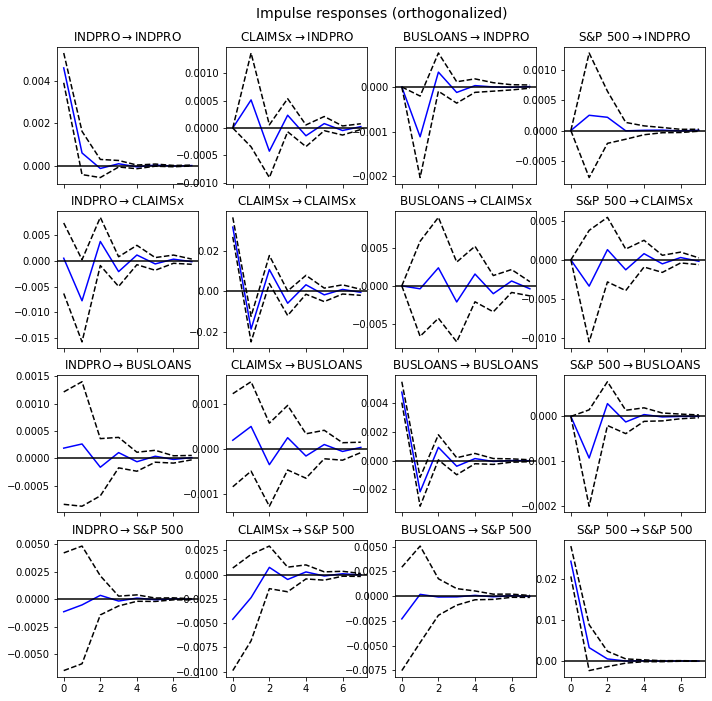

The function plots the Forecast Error Variance Decomposition
FEVD for INDPRO
        INDPRO   CLAIMSx  BUSLOANS   S&P 500
0     1.000000  0.000000  0.000000  0.000000
1     0.931836  0.011306  0.054105  0.002753
2     0.918537  0.018698  0.058010  0.004755
3     0.915860  0.020938  0.058461  0.004740
4     0.915060  0.021763  0.058441  0.004736
5     0.914810  0.022030  0.058422  0.004737
6     0.914727  0.022116  0.058419  0.004738
7     0.914699  0.022142  0.058420  0.004739
8     0.914690  0.022150  0.058421  0.004739
9     0.914687  0.022152  0.058422  0.004739
10    0.914686  0.022153  0.058422  0.004740
11    0.914685  0.022153  0.058422  0.004740

FEVD for CLAIMSx
        INDPRO   CLAIMSx  BUSLOANS   S&P 500
0     0.000250  0.999750  0.000000  0.000000
1     0.042195  0.949849  0.000103  0.007853
2     0.047481  0.940597  0.003666  0.008256
3     0.048864  0.935791  0.006324  0.009021
4     0.049197  0.933730  0.007746  0.009327
5     0.049277  0.932901  0.008366  0.009456
6    

{'INDPRO': 6, 'CLAIMSx': 2, 'BUSLOANS': 6, 'S&P 500': 3}

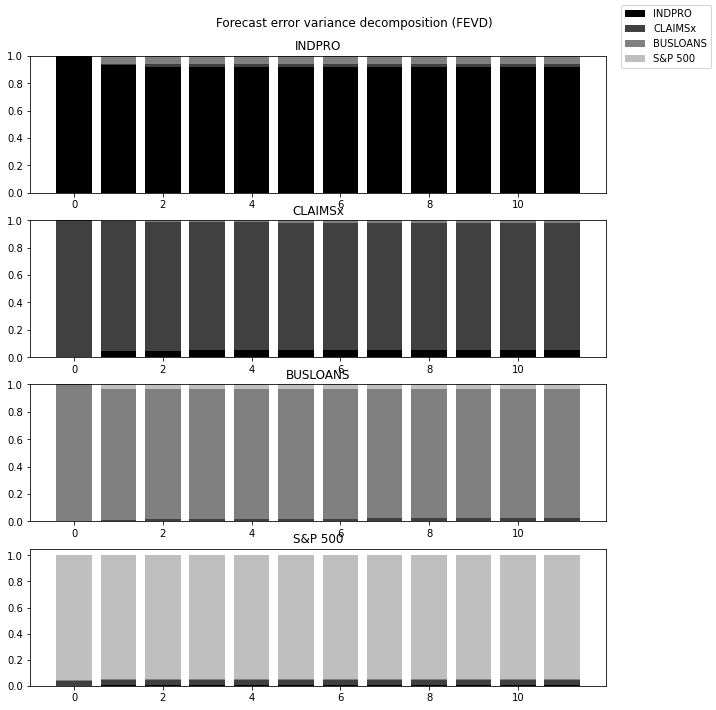

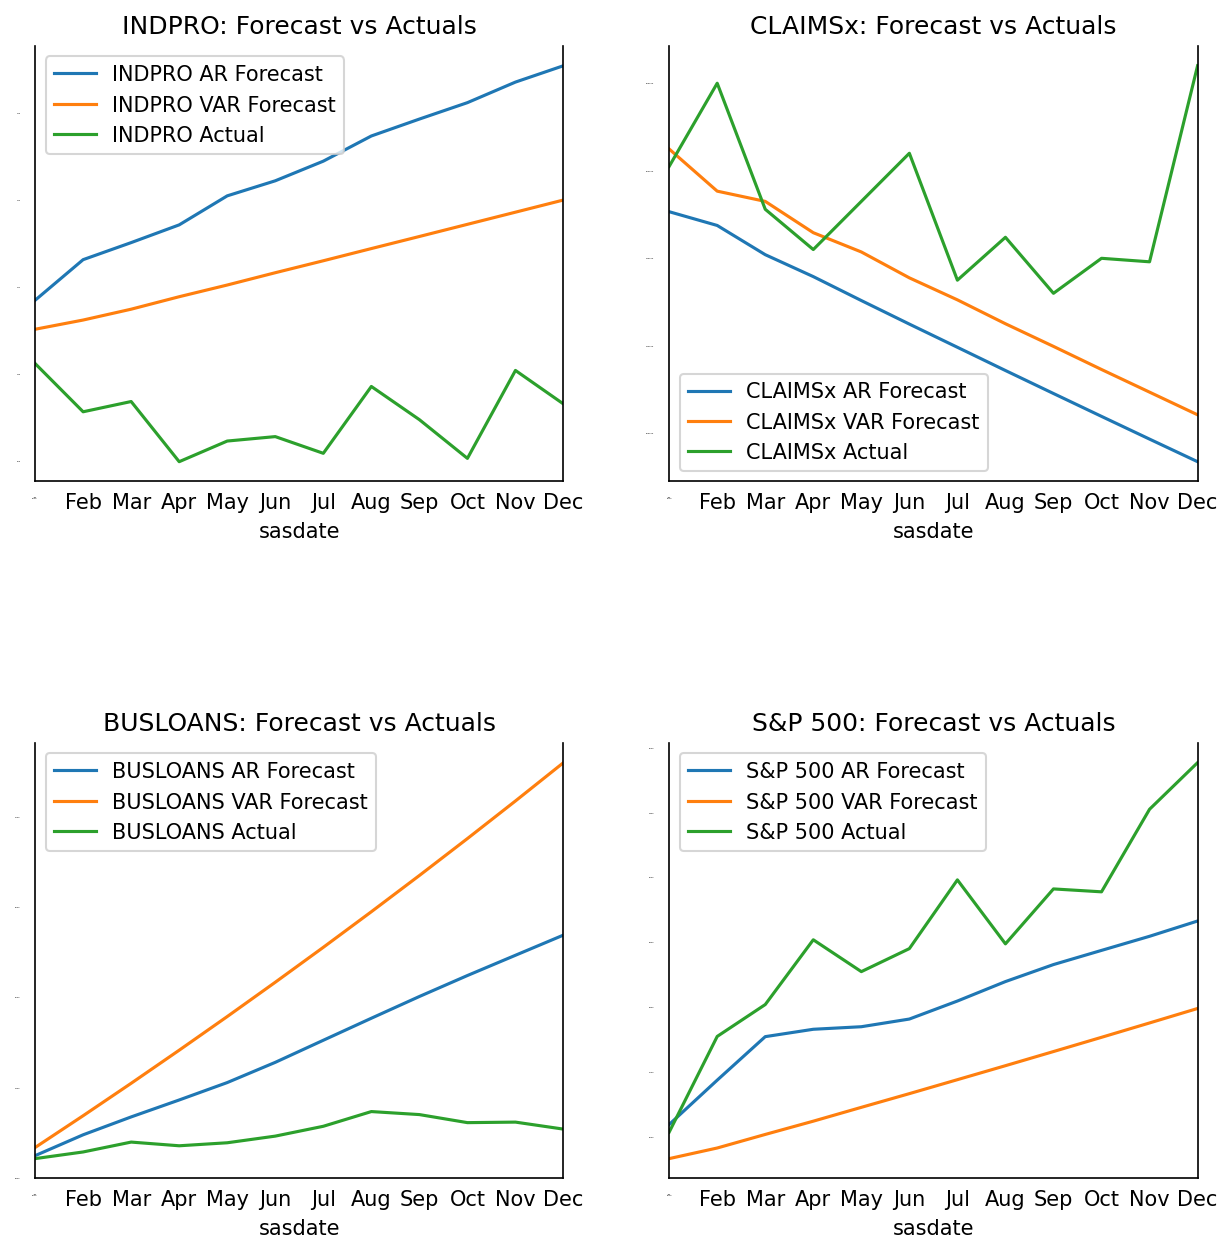

In [20]:
try_variables = ['BUSLOANS','CLAIMSx',"INDPRO","S&P 500"]
cointegration_test(df[try_variables],alpha = 0.01)
cointegration_test(USA[try_variables],alpha = 0.01)
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
#coin_evaluate_plot(USA[try_variables],code_rep,num=12)
evaluate_plot(USA[try_variables],code_rep,num=12)

In [24]:
diff_USA = differencing_data(USA.dropna())
diff_USA.columns

Augumented Dickey-Fuller Test:
ADS test statistic       0.120322
p-value                  0.967421
# lags used              4.000000
# observations          93.000000
Critical Value (1%)     -3.502705
Critical Value (5%)     -2.893158
Critical Value (10%)    -2.583637
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic     -6.935902e+00
p-value                 1.054861e-09
# lags used             3.000000e+00
# observations          9.300000e+01
Critical Value (1%)    -3.502705e+00
Critical Value (5%)    -2.893158e+00
Critical Value (10%)   -2.583637e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
RPI needs 1 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic       0.051489
p-value                  0.962589
# lags used              4.0

Index(['RPI_1', 'W875RX1_1', 'DPCERA3M086SBEA_1', 'CMRMTSPLx_1', 'RETAILx_1',
       'INDPRO_2', 'IPFPNSS_1', 'IPFINAL_1', 'IPCONGD_1', 'IPDCONGD_1',
       ...
       'DSERRG3M086SBEA_1', 'CES0600000008_1', 'CES2000000008_1',
       'CES3000000008_1', 'UMCSENTx_1', 'MZMSL_1', 'DTCOLNVHFNM_1',
       'DTCTHFNM_1', 'INVEST_1', 'VXOCLSx_1'],
      dtype='object', length=128)

In [26]:
for column in diff_USA.columns:
    print(column)

RPI_1
W875RX1_1
DPCERA3M086SBEA_1
CMRMTSPLx_1
RETAILx_1
INDPRO_2
IPFPNSS_1
IPFINAL_1
IPCONGD_1
IPDCONGD_1
IPNCONGD_1
IPBUSEQ_1
IPMAT_1
IPDMAT_1
IPNMAT_1
IPMANSICS_1
IPB51222S_0
IPFUELS_1
CUMFNS_1
HWI_1
HWIURATIO_1
CLF16OV_1
CE16OV_1
UNRATE_1
UEMPMEAN_1
UEMPLT5_1
UEMP5TO14_1
UEMP15OV_2
UEMP15T26_1
UEMP27OV_0
CLAIMSx_1
PAYEMS_1
USGOOD_1
CES1021000001_2
USCONS_1
MANEMP_1
DMANEMP_2
NDMANEMP_1
SRVPRD_1
USTPU_0
USWTRADE_1
USTRADE_1
USFIRE_1
USGOVT_1
CES0600000007_0
AWOTMAN_0
AWHMAN_0
HOUST_1
HOUSTNE_0
HOUSTMW_0
HOUSTS_1
HOUSTW_1
PERMIT_1
PERMITNE_0
PERMITMW_1
PERMITS_1
PERMITW_1
ACOGNO_1
AMDMNOx_1
ANDENOx_0
AMDMUOx_1
BUSINVx_1
ISRATIOx_1
M1SL_1
M2SL_1
M2REAL_1
BOGMBASE_0
TOTRESNS_1
NONBORRES_1
BUSLOANS_1
REALLN_2
NONREVSL_1
CONSPI_1
S&P 500_2
S&P: indust_2
S&P div yield_2
S&P PE ratio_2
FEDFUNDS_2
CP3Mx_0
TB3MS_2
TB6MS_2
GS1_2
GS5_1
GS10_1
AAA_1
BAA_1
COMPAPFFx_1
TB3SMFFM_0
TB6SMFFM_0
T1YFFM_1
T5YFFM_1
T10YFFM_1
AAAFFM_1
BAAFFM_1
TWEXAFEGSMTHx_1
EXSZUSx_1
EXJPUSx_1
EXUSUKx_1
EXCAUSx_1
WPSFD4

In [17]:
a = ["CES0600000007","S&P 500","COMPAPFFx","USFIRE"]
cointegration_test(df[a],alpha = 0.01)
grangers_causation_matrix(df[a].dropna(),variables=a)

Name   ::  Test Stat > C(99.0%)    =>   Signif  
 ----------------------------------------
CES0600000007 ::  45.77     > 46.5716   =>   False
S&P 500 ::  18.71     > 29.5147   =>   False
COMPAPFFx ::  7.71      > 16.364    =>   False
USFIRE ::  0.06      > 6.9406    =>   False


CES0600000007_x S&P 500_x  COMPAPFFx_x  USFIRE_x
CES0600000007_y               1     False       0.0022    0.0115
S&P 500_y                0.0497         1       0.0111    0.0082
COMPAPFFx_y               False     False       1.0000    0.0364
USFIRE_y                  False     0.045       0.0437    1.0000

Name   ::  Test Stat > C(95.0%)    =>   Signif  
 ----------------------------------------
TOTRESNS ::  88.36     > 60.0627   =>   True
COMPAPFFx ::  53.69     > 40.1749   =>   True
CLAIMSx ::  31.55     > 24.2761   =>   True
INDPRO ::  14.16     > 12.3212   =>   True
S&P 500 ::  6.66      > 4.1296    =>   True
                               AR Model Results                               
Dep. Variable:                      I  -                  N                  D
Model:                          AR(1)   Log Likelihood                 -59.789
Method:                          cmle   S.D. of innovations              0.489
Date:                Fri, 18 Dec 2020   AIC                             -1.360
Time:                        18:25:08   BIC                             -1.274
Sample:                    11-01-2011   HQIC                            -1.326
                         - 12-01-2018                                         
                 coef    std err          z      P>|z| 

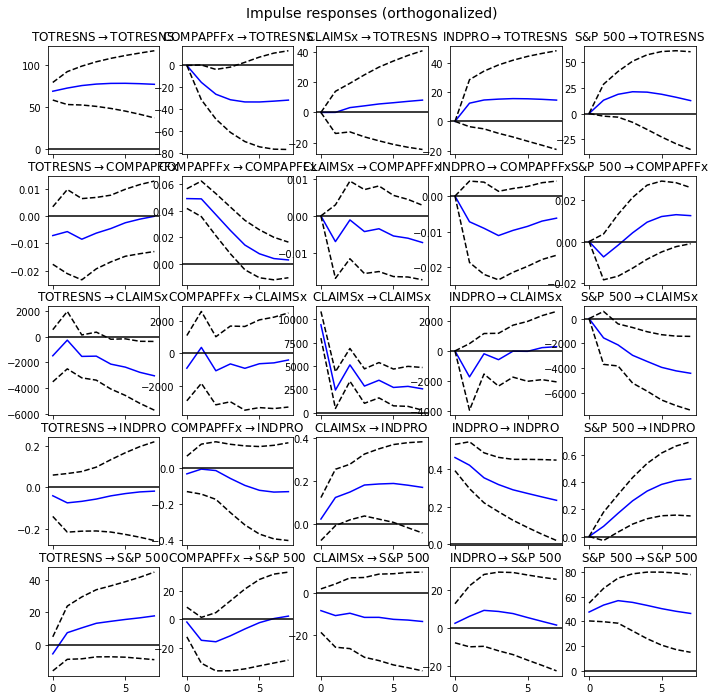

The function plots the Forecast Error Variance Decomposition
FEVD for TOTRESNS
      TOTRESNS  COMPAPFFx   CLAIMSx    INDPRO   S&P 500
0     1.000000   0.000000  0.000000  0.000000  0.000000
1     0.947530   0.022221  0.000000  0.014544  0.015704
2     0.897182   0.052226  0.000583  0.020873  0.029136
3     0.862526   0.074787  0.001158  0.023675  0.037854
4     0.841154   0.090015  0.001825  0.025298  0.041708
5     0.829558   0.099556  0.002480  0.026240  0.042165
6     0.823943   0.105482  0.003191  0.026770  0.040614
7     0.821731   0.109261  0.003954  0.027004  0.038050
8     0.821147   0.111893  0.004792  0.027055  0.035113
9     0.821139   0.113964  0.005709  0.027000  0.032188
10    0.821075   0.115805  0.006713  0.026901  0.029505
11    0.820611   0.117581  0.007809  0.026800  0.027200

FEVD for COMPAPFFx
      TOTRESNS  COMPAPFFx   CLAIMSx    INDPRO   S&P 500
0     0.020436   0.979564  0.000000  0.000000  0.000000
1     0.016294   0.952862  0.009590  0.010340  0.010915
2    

{'INDPRO': 1, 'CLAIMSx': 2, 'TOTRESNS': 4, 'S&P 500': 1, 'COMPAPFFx': 5}

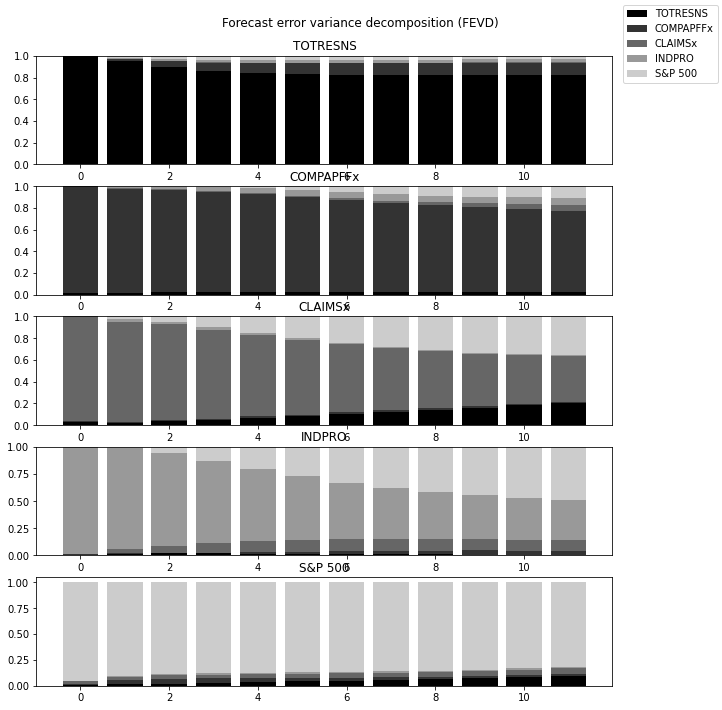

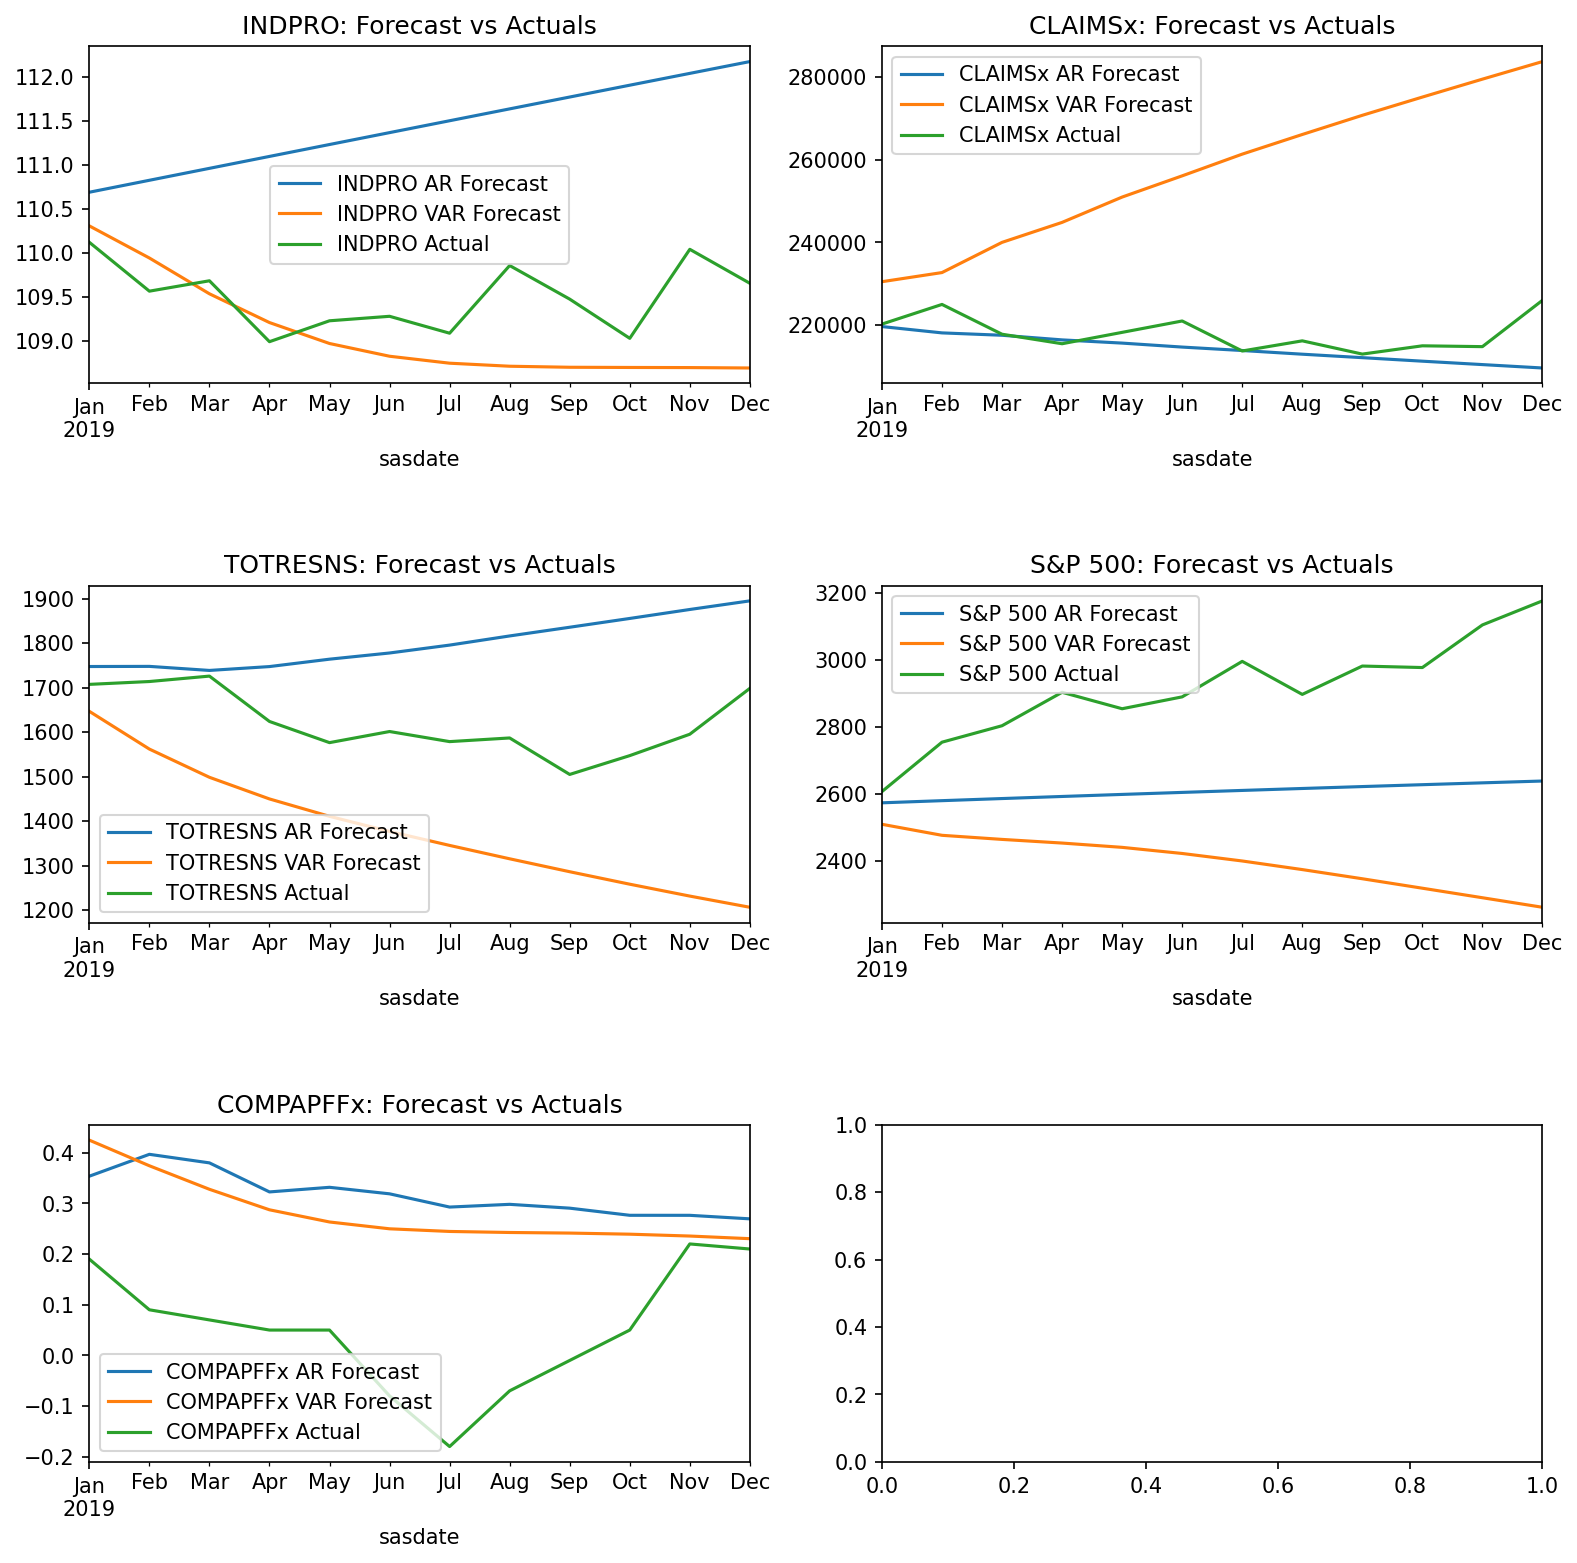

In [69]:
try_variables = ["TOTRESNS","COMPAPFFx","CLAIMSx","INDPRO","S&P 500"] # GS1ではrmse 75.001
cointegration_test(USA[try_variables],alpha = 0.05)
code_rep = {key: val for key, val in zip(original_data.loc["Transform:"].index,original_data.loc["Transform:"].values) if key in try_variables}
coin_evaluate_plot(USA[try_variables],code_rep,num=12)
#evaluate_plot(USA[try_variables],code_rep,num=12)